# The Fitbit Whodunnit
By Kathryn Salts & Michael Moran

## Table of contents
1. [Project Planning](#project-planning)
1. [Acquisition](#acquisition)
1. [Preparation](#preparation)
1. [Exploration](#exploration)
1. [Modeling](#modeling)

## Project Planning <a name="project-planning"></a>

### Goals

1. Identify who was wearing the Fitbit
1. Predict what next two weeks of data will be

### Deliverables

1. CSV with predictions of next two weeks of data
1. Two slides describing the Fitbit data and our predictions. Must contain at least one visualization
1. Jupyter notebook showing work
1. Tidy dataset

### Data Dictionary & Domain Knowledge

- Caloric burn per day
    - avg man: 2,200 - 3,000
    - avg woman: 1,800 - 2,2000
    - [Source](https://www.livestrong.com/article/278257-how-many-calories-does-the-body-naturally-burn-per-day/)

### Hypotheses

1. The wearer is fairly active, but not mostly mobile activity, possibly stationary like lifting weights.
1. Wearer is not someone in a drug trial because there are not many entries in the food log. We would expect them to be logging food to see if there are any interactions.
1. The wearer is likely not wearing the tracker while sleeping. Average inactivity/activity minutes is 16-17 hours per day.
    - Wouldn't expect a person testing fitness equipment to wear it that long
    - Would make sense for an employee or drug trial participant (but we would expect the drug trial participant to wear it while sleeping)
1. Likely not a person testing fitness equipment because there are food log entries for one week; and also likely not a drug trial participant for the same reason
    - Makes it more likely to be an employee who lost the motivation to log food
1. Looks like person stopped wearing tracker on 12/7/18 because there are food log entries and caloric intake entries for dates after the 7th, but the activity log stops on the 6th.

### Thoughts & Questions

1. What does the weekend data look like? This may tell us whether they work there or are in a drug trial (likely to wear the fitbit on the weekend) or are testing fitness equipment (not likely to wear on weekend).
    - There is more activity on the weekend than weekdays.
1. Why does the activity tracking data end on 12/7 but the food log and caloric intake log keep going?
    - We aren't comfortable speculating on this with current evidence.
1. What do we do with the food log entries?
    - Got rid of them for now because it doesn't appear to be worth the effort to wrangle them

### Prepare the Environment

In [1]:
import os
from pprint import pprint
import io
from datetime import timedelta
from importlib import reload

import adalib
import acquire
import prepare

from pylab import rcParams
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
import pandas as pd
import math
from statsmodels.tsa.api import Holt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import (
    plot_cross_validation_metric,
    plot_forecast_component,
)

**Reload modules to capture changes**

In [2]:
adalib = reload(adalib)
acquire = reload(acquire)
prepare = reload(prepare)

## Acquisition <a name="acquisition"></a>

In [3]:
df_cals_in, df_activities, df_food_log = acquire.acquire_fitbit()

In [4]:
# pprint(cals_in)

In [5]:
# pprint(activities)

In [6]:
# pprint(food_log)

## Preparation <a name="preparation"></a>

### Prepare Caloric Intake Dataframe

1. Remove columns from calories_in and convert to int type
1. Convert the date column to datetime type

In [7]:
df_cals_in = prepare.df_cals_in_prepare(df_cals_in)

In [8]:
prepare.has_every_day(df_cals_in.date)

True

In [9]:
df_cals_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 2 columns):
date           247 non-null datetime64[ns]
calories_in    247 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.9 KB


### Prepare Activities Dataframe

1. Remove commas from calories_burned, steps, minutes_sedentary, activity calories and convert those columns to int type
1. Convert date column to datetime type

In [10]:
df_activities = prepare.df_activities_prepare(df_activities)

In [11]:
prepare.has_every_day(df_activities.date)

True

In [12]:
df_activities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 10 columns):
date                      225 non-null datetime64[ns]
calories_burned           225 non-null int64
steps                     225 non-null int64
distance                  225 non-null float64
floors                    225 non-null int64
minutes_sedentary         225 non-null int64
minutes_lightly_active    225 non-null int64
minutes_fairly_active     225 non-null int64
minutes_very_active       225 non-null int64
activity_calories         225 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(8)
memory usage: 17.7 KB


### Prepare Food Log Dataframe

1. Grab only the data corresponding to the nutritional stats, not the specific food entries, which do not appear to be worth the effort
1. Reset the index, rename column to date and convert to datetime type

In [13]:
df_food_log, _ = prepare.df_food_log_prepare(df_food_log)

In [14]:
prepare.has_every_day(df_food_log.date)

True

In [15]:
df_food_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 8 columns):
date        247 non-null datetime64[ns]
calories    247 non-null object
fat         247 non-null object
fiber       247 non-null object
carbs       247 non-null object
sodium      247 non-null object
protein     247 non-null object
water       247 non-null object
dtypes: datetime64[ns](1), object(7)
memory usage: 15.5+ KB


### Merge DataFrames, Sort, and Index by Date

1. Merge the three dataframes on their date column using an outer join
1. Drop the columns calories_in, calories, fat, fiber, carbs, sodium, protein, water because they contain fewer than 10 non-zero entries.

In [16]:
df = prepare.prepare_fitbit(df_cals_in, df_activities, df_food_log)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247 entries, 2018-04-26 to 2018-12-28
Data columns (total 9 columns):
calories_burned           225 non-null float64
steps                     225 non-null float64
distance                  225 non-null float64
floors                    225 non-null float64
minutes_sedentary         225 non-null float64
minutes_lightly_active    225 non-null float64
minutes_fairly_active     225 non-null float64
minutes_very_active       225 non-null float64
activity_calories         225 non-null float64
dtypes: float64(9)
memory usage: 19.3 KB


### Summarize Data

In [18]:
adalib.summarize(df)

RANDOM SAMPLE OF 10
            calories_burned    steps  distance  floors  minutes_sedentary  \
date                                                                        
2018-06-15           3422.0   7249.0      3.42    14.0              693.0   
2018-07-06           2144.0      0.0      0.00     0.0             1440.0   
2018-11-16           3780.0  12286.0      5.73    13.0              576.0   
2018-09-30           4184.0  15991.0      7.54     9.0              652.0   
2018-05-18           4376.0  13958.0      6.58     7.0              682.0   
2018-12-01           3813.0  14510.0      7.27     7.0              527.0   
2018-07-30           2212.0    357.0      0.17     1.0              947.0   
2018-07-01           3090.0   4714.0      2.22     4.0             1005.0   
2018-11-05           3710.0  13441.0      6.36     8.0              666.0   
2018-10-15           2956.0   5982.0      2.82    12.0              915.0   

            minutes_lightly_active  minutes_fairly_acti

### Handle Missing Values

In [19]:
df.isnull().sum()

calories_burned           22
steps                     22
distance                  22
floors                    22
minutes_sedentary         22
minutes_lightly_active    22
minutes_fairly_active     22
minutes_very_active       22
activity_calories         22
dtype: int64

In [20]:
adalib.df_missing_vals_by_col(df)

nmissing  percentage  nempty
calories_burned               22    8.906883       0
steps                         22    8.906883       0
distance                      22    8.906883       0
floors                        22    8.906883       0
minutes_sedentary             22    8.906883       0
minutes_lightly_active        22    8.906883       0
minutes_fairly_active         22    8.906883       0
minutes_very_active           22    8.906883       0
activity_calories             22    8.906883       0

In [21]:
df_bad_rows = adalib.df_missing_vals_by_row(df)
df_bad_rows[(df_bad_rows.nmissing > 0) | (df_bad_rows.nempty > 0)]

nmissing  percentage  nempty
date                                    
2018-12-07         9       100.0       0
2018-12-08         9       100.0       0
2018-12-09         9       100.0       0
2018-12-10         9       100.0       0
2018-12-11         9       100.0       0
2018-12-12         9       100.0       0
2018-12-13         9       100.0       0
2018-12-14         9       100.0       0
2018-12-15         9       100.0       0
2018-12-16         9       100.0       0
2018-12-17         9       100.0       0
2018-12-18         9       100.0       0
2018-12-19         9       100.0       0
2018-12-20         9       100.0       0
2018-12-21         9       100.0       0
2018-12-22         9       100.0       0
2018-12-23         9       100.0       0
2018-12-24         9       100.0       0
2018-12-25         9       100.0       0
2018-12-26         9       100.0       0
2018-12-27         9       100.0       0
2018-12-28         9       100.0       0

In [22]:
df[df.isnull().any(axis=1)]

calories_burned  steps  distance  floors  minutes_sedentary  \
date                                                                      
2018-12-07              NaN    NaN       NaN     NaN                NaN   
2018-12-08              NaN    NaN       NaN     NaN                NaN   
2018-12-09              NaN    NaN       NaN     NaN                NaN   
2018-12-10              NaN    NaN       NaN     NaN                NaN   
2018-12-11              NaN    NaN       NaN     NaN                NaN   
2018-12-12              NaN    NaN       NaN     NaN                NaN   
2018-12-13              NaN    NaN       NaN     NaN                NaN   
2018-12-14              NaN    NaN       NaN     NaN                NaN   
2018-12-15              NaN    NaN       NaN     NaN                NaN   
2018-12-16              NaN    NaN       NaN     NaN                NaN   
2018-12-17              NaN    NaN       NaN     NaN                NaN   
2018-12-18              NaN    NaN       NaN     NaN                NaN   
2018-12-19              NaN    NaN       NaN     NaN                NaN   
2018-12-20              NaN    NaN       NaN     NaN                NaN   
2018-12-21              NaN    NaN       NaN     NaN                NaN   
2018-12-22              NaN    NaN       NaN     NaN                NaN   
2018-12-23              NaN    NaN       NaN     NaN                NaN   
2018-12-24              NaN    NaN       NaN     NaN                NaN   
2018-12-25              NaN    NaN       NaN     NaN                NaN   
2018-12-26              NaN    NaN       NaN     NaN                NaN   
2018-12-27              NaN    NaN       NaN     NaN                NaN   
2018-12-28              NaN    NaN       NaN     NaN                NaN   

            minutes_lightly_active  minutes_fairly_active  \
date                                                        
2018-12-07                     NaN                    NaN   
2018-12-08                     NaN                    NaN   
2018-12-09                     NaN                    NaN   
2018-12-10                     NaN                    NaN   
2018-12-11                     NaN                    NaN   
2018-12-12                     NaN                    NaN   
2018-12-13                     NaN                    NaN   
2018-12-14                     NaN                    NaN   
2018-12-15                     NaN                    NaN   
2018-12-16                     NaN                    NaN   
2018-12-17                     NaN                    NaN   
2018-12-18                     NaN                    NaN   
2018-12-19                     NaN                    NaN   
2018-12-20                     NaN                    NaN   
2018-12-21                     NaN                    NaN   
2018-12-22                     NaN                    NaN   
2018-12-23                     NaN                    NaN   
2018-12-24                     NaN                    NaN   
2018-12-25                     NaN                    NaN   
2018-12-26                     NaN                    NaN   
2018-12-27                     NaN                    NaN   
2018-12-28                     NaN                    NaN   

            minutes_very_active  activity_calories  
date                                                
2018-12-07                  NaN                NaN  
2018-12-08                  NaN                NaN  
2018-12-09                  NaN                NaN  
2018-12-10                  NaN                NaN  
2018-12-11                  NaN                NaN  
2018-12-12                  NaN                NaN  
2018-12-13                  NaN                NaN  
2018-12-14                  NaN                NaN  
2018-12-15                  NaN                NaN  
2018-12-16                  NaN                NaN  
2018-12-17                  NaN                NaN  
2018-12-18                  NaN                NaN  
2018

In [23]:
df_forecast = df[df.isnull().any(axis=1)]

**Drop the missing rows**

In [24]:
df = df.dropna()

In [25]:
adalib.df_missing_vals_by_col(df)

nmissing  percentage  nempty
calories_burned                0         0.0       0
steps                          0         0.0       0
distance                       0         0.0       0
floors                         0         0.0       0
minutes_sedentary              0         0.0       0
minutes_lightly_active         0         0.0       0
minutes_fairly_active          0         0.0       0
minutes_very_active            0         0.0       0
activity_calories              0         0.0       0

### Handle Duplicates

In [26]:
(df.index.value_counts(dropna=False) > 1).sum()

0

**No duplicates in index (dates)**

### Fix Data Types

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Freq: D
Data columns (total 9 columns):
calories_burned           225 non-null float64
steps                     225 non-null float64
distance                  225 non-null float64
floors                    225 non-null float64
minutes_sedentary         225 non-null float64
minutes_lightly_active    225 non-null float64
minutes_fairly_active     225 non-null float64
minutes_very_active       225 non-null float64
activity_calories         225 non-null float64
dtypes: float64(9)
memory usage: 17.6 KB


**Datatypes look acceptable**

### Handle Outliers

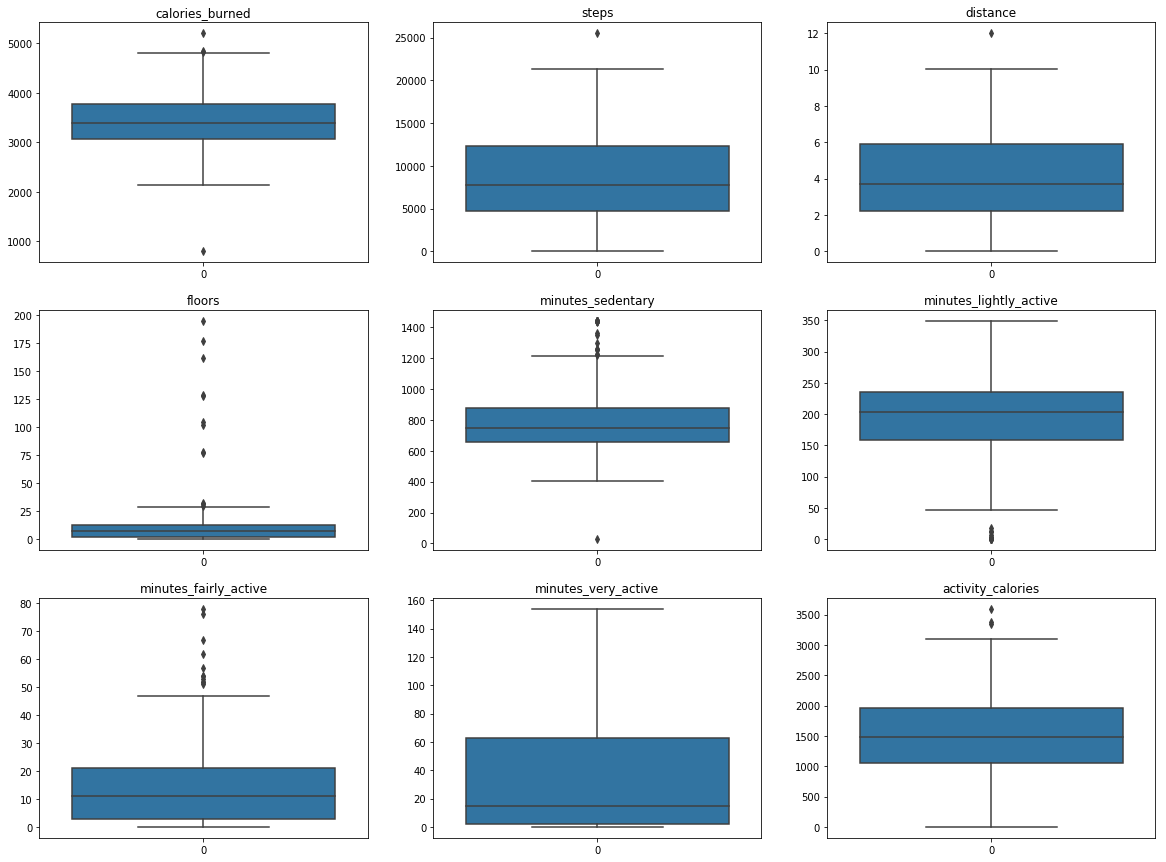

In [28]:
plt.figure(figsize=(20, 15))

for i, col in enumerate(df.columns):
    plot_number = i + 1
    series = df[col]
    plt.subplot(3, 3, plot_number)
    plt.title(col)
    sns.boxplot(data=series)

**Remove the following outliers**
- calories_burned: remove < 1000
- minutes_sedentary < 200

In [29]:
df = df[df.calories_burned > 1000]
df = df[df.minutes_sedentary > 150]

### Check Missing Values

In [30]:
df.isnull().sum()

calories_burned           0
steps                     0
distance                  0
floors                    0
minutes_sedentary         0
minutes_lightly_active    0
minutes_fairly_active     0
minutes_very_active       0
activity_calories         0
dtype: int64

### Summarize Data

**Thoughts**
- What is distance measured in?
    - Probably miles
- What does "floors" mean?
    - Probably has to do with steps.
- What is the difference between the calories_in and calories columns?
    - Not sure but we dropped calories_in.

**Conclusions**

1. calories_in has a mean of 51; looks like it is mostly 0
1. The mean of calories_burned appears to be above the average for a man and way above average for a woman
1. Steps and distance metrics appear to match up
1. This person is sedentary for on average 13+ hours
1. There appear to be days where the Fitbit was not worn or not worn much. Min of calories_burned is 799. Min of steps and distance and floors is 0. Minutes sedentary is 1440 (24 hours).
1. After looking at the binned data, it looks like this person was active much of the time by looking at calories_burned and steps.

## Exploration  <a name="exploration"></a>

### Train-Test Split

In [31]:
aggregation = "sum"

train = df[:"2018-09"].resample("D").agg(aggregation)
test = df["2018-10":].resample("D").agg(aggregation)

In [32]:
print("Observations: %d" % (len(train.values) + len(test.values)))
print("Training Observations: %d" % (len(train)))
print("Testing Observations: %d" % (len(test)))

Observations: 225
Training Observations: 158
Testing Observations: 67


In [33]:
pd.concat([train.head(3), train.tail(3)])

calories_burned    steps  distance  floors  minutes_sedentary  \
date                                                                        
2018-04-26           2635.0   2931.0      1.38     2.0             1347.0   
2018-04-27           3649.0   9971.0      4.70    19.0             1158.0   
2018-04-28           3379.0   3521.0      1.66     2.0              702.0   
2018-09-28           2970.0   4531.0      2.14     4.0              775.0   
2018-09-29           3043.0   7043.0      3.32     5.0              788.0   
2018-09-30           4184.0  15991.0      7.54     9.0              652.0   

            minutes_lightly_active  minutes_fairly_active  \
date                                                        
2018-04-26                    93.0                    0.0   
2018-04-27                   219.0                   46.0   
2018-04-28                   155.0                   22.0   
2018-09-28                   235.0                    0.0   
2018-09-29                   218.0                    4.0   
2018-09-30                   254.0                   45.0   

            minutes_very_active  activity_calories  
date                                                
2018-04-26                  0.0              566.0  
2018-04-27                 17.0             1752.0  
2018-04-28                 11.0             1124.0  
2018-09-28                  0.0             1068.0  
2018-09-29                  5.0             1220.0  
2018-09-30                 72.0             2504.0

In [34]:
pd.concat([test.head(3), test.tail(3)])

calories_burned    steps  distance  floors  minutes_sedentary  \
date                                                                        
2018-10-01           3180.0   8307.0      3.92     8.0              813.0   
2018-10-02           3162.0   8702.0      4.10     9.0              872.0   
2018-10-03           3584.0  10729.0      5.06     6.0              773.0   
2018-12-04           3384.0  13763.0      6.49    13.0              608.0   
2018-12-05           3670.0  13865.0      6.52    12.0              739.0   
2018-12-06           3669.0  14774.0      6.96     9.0              647.0   

            minutes_lightly_active  minutes_fairly_active  \
date                                                        
2018-10-01                   201.0                    5.0   
2018-10-02                   141.0                   11.0   
2018-10-03                   186.0                    7.0   
2018-12-04                   199.0                   11.0   
2018-12-05                   200.0                   12.0   
2018-12-06                   198.0                    4.0   

            minutes_very_active  activity_calories  
date                                                
2018-10-01                 24.0             1330.0  
2018-10-02                 34.0             1205.0  
2018-10-03                 69.0             1715.0  
2018-12-04                 67.0             1663.0  
2018-12-05                 69.0             1968.0  
2018-12-06                 78.0             1962.0

### Visualizations

#### Histograms

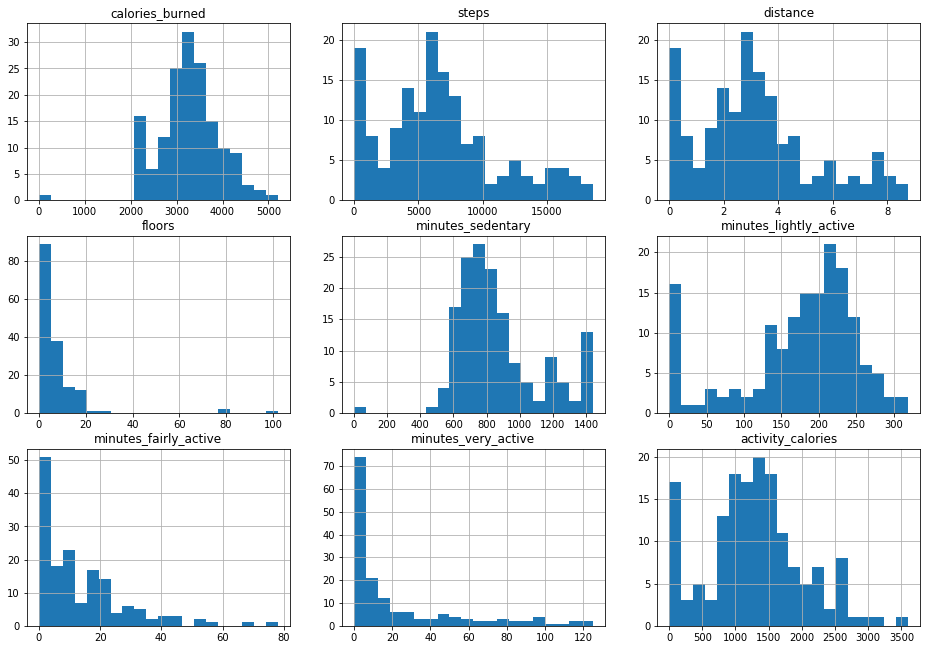

In [35]:
plt.figure(figsize=(16, 15))

for i, col in enumerate(train.columns):
    plot_number = i + 1
    series = train[col]
    plt.subplot(4, 3, plot_number)
    plt.title(col)
    series.hist(bins=20, density=False, cumulative=False, log=False)

#### Heatmap

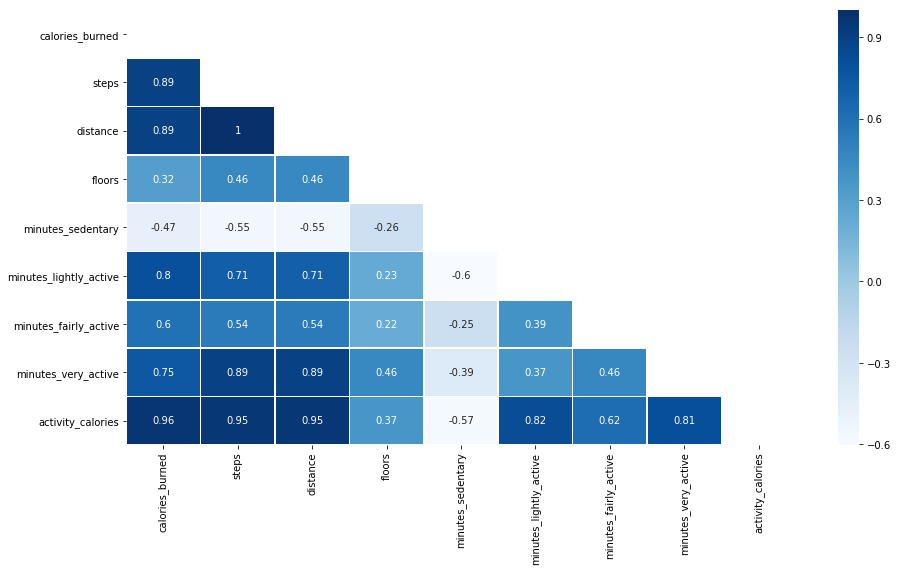

In [36]:
plt.figure(figsize=(15, 8))
corr = train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, cmap="Blues", annot=True, mask=mask, linewidths=.5)

#### Calories burned

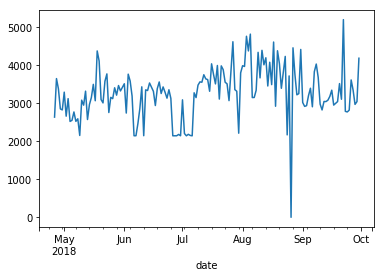

In [37]:
# Daily
train.calories_burned.plot()

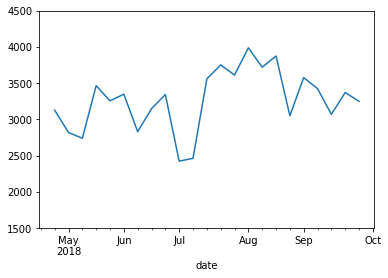

In [38]:
# Weekly
train.resample("W").calories_burned.mean().plot(ylim=(1500, 4500))

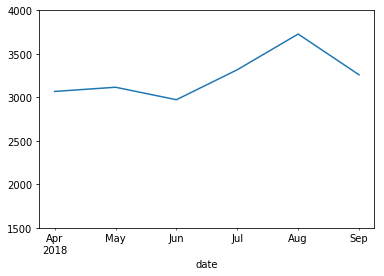

In [39]:
# Monthly
train.calories_burned.resample("MS").mean().plot(ylim=(1500, 4000))

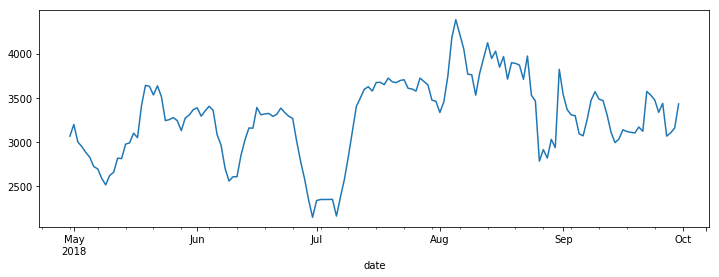

In [40]:
# 5 period rolling mean and plot
train.calories_burned.rolling(5).mean().plot(figsize=(12, 4))

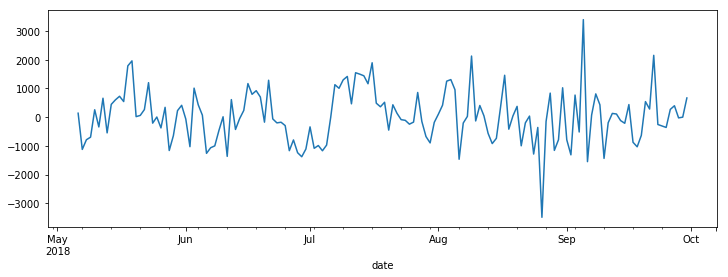

In [41]:
# 10 period difference and plot
train.calories_burned.diff(periods=10).plot(figsize=(12, 4))

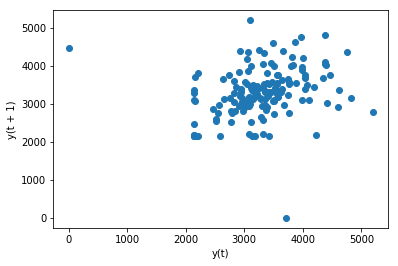

In [42]:
# lag plot
pd.plotting.lag_plot(train.calories_burned)

In [43]:
# pearson correlation
df_corr = pd.concat(
    [train.calories_burned.shift(1), train.calories_burned], axis=1
)
df_corr.columns = ["t-1", "t+1"]
result = df_corr.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.279149
t+1  0.279149  1.000000


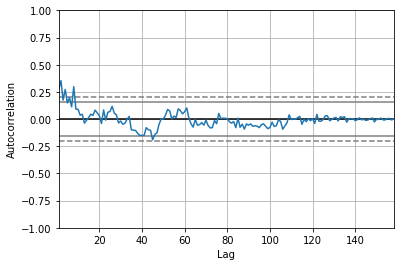

In [44]:
# autocorrelation plot
pd.plotting.autocorrelation_plot(train.calories_burned)

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


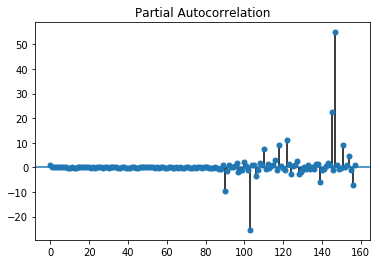

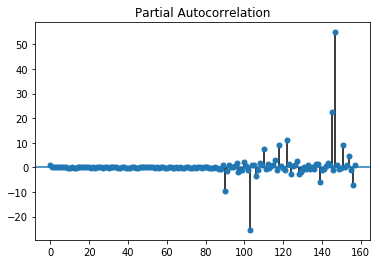

In [45]:
# partial autocorrelation plot
sm.graphics.tsa.plot_pacf(train.calories_burned)

## Modeling <a name="modeling"></a>

In [46]:
def plot_data_and_predictions(train, test, predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(train, test, predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)
        plt.title(f"{train.name}")

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(f"{train.name}\n{label}")

    plt.legend(loc='best')
    plt.show()

### Simple Average

In [47]:
def ts_simple_average(train, test):
    yhat = pd.DataFrame(dict(actual=test))
    yhat["avg_forecast"] = train.mean()
    plot_and_eval(train, test, yhat.avg_forecast, yhat.actual)
    return yhat

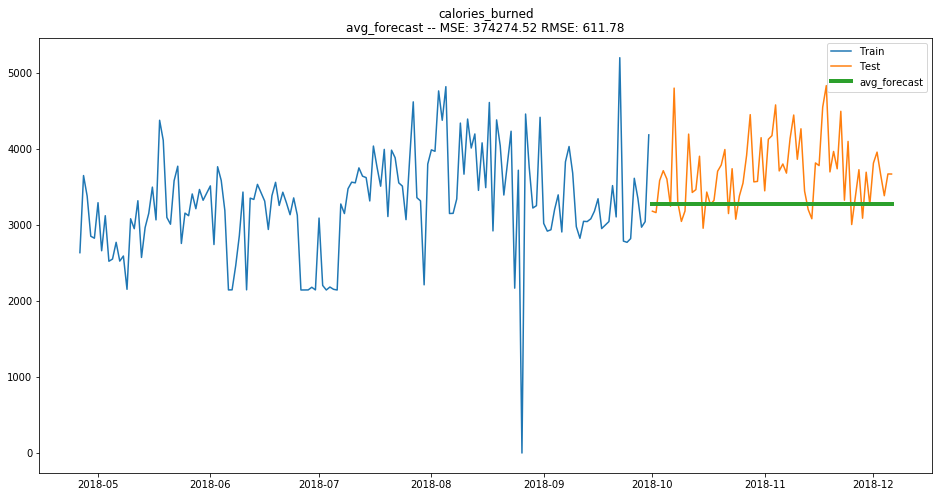

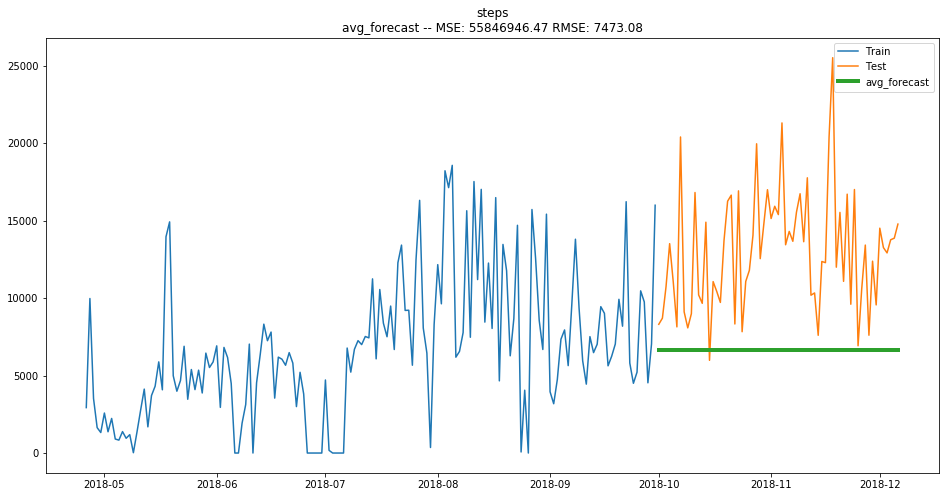

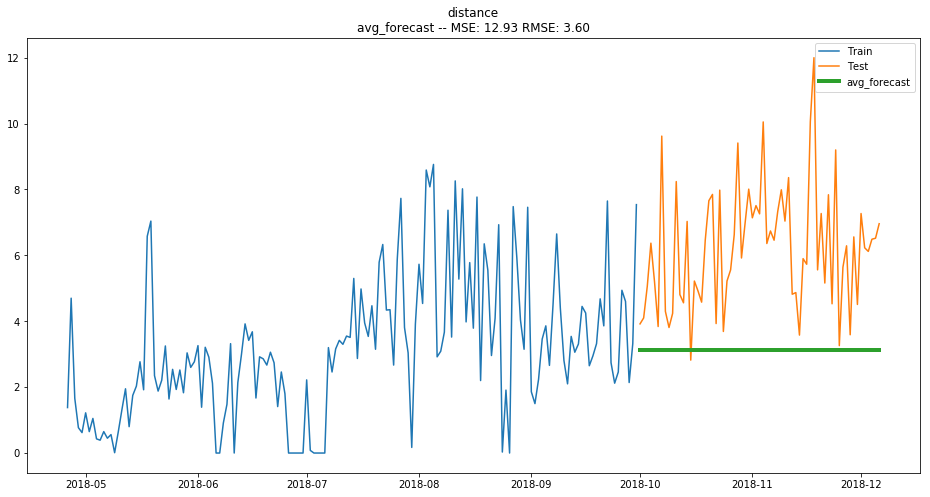

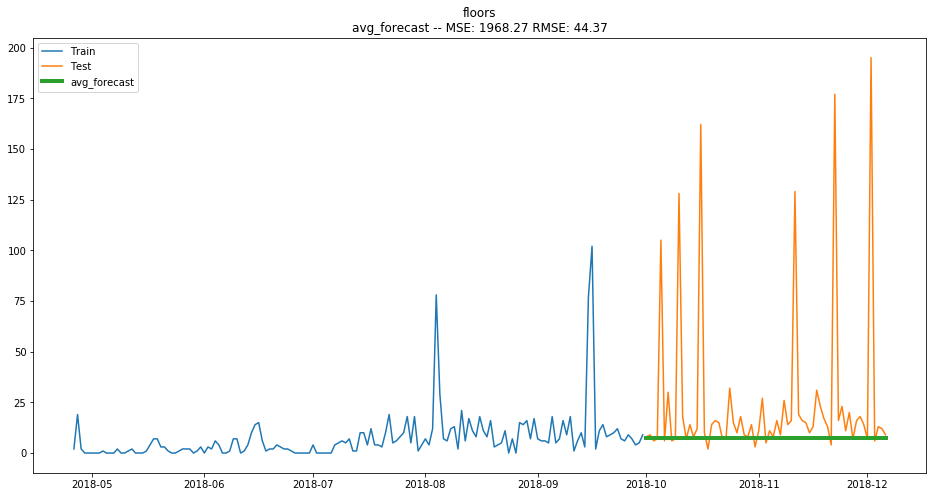

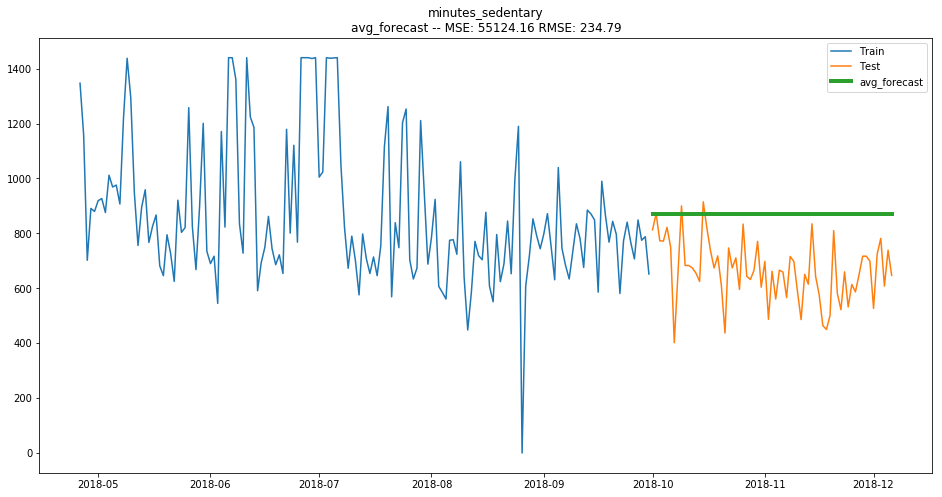

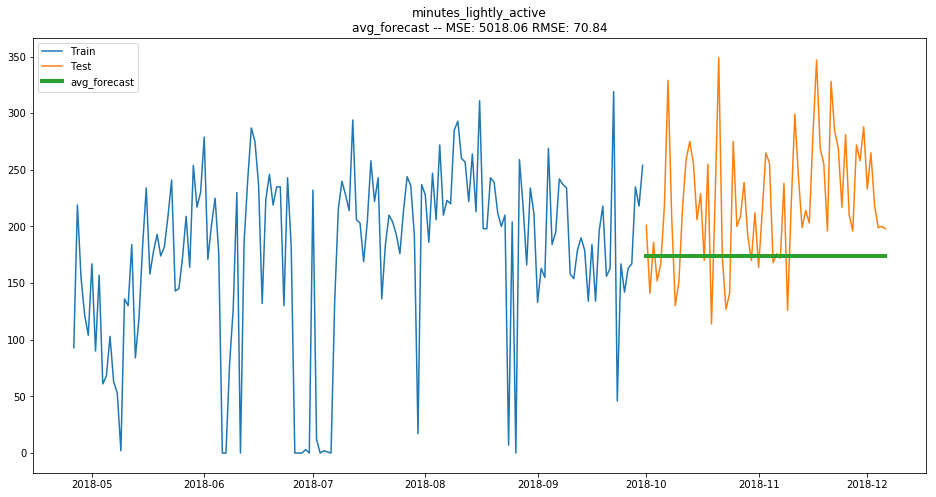

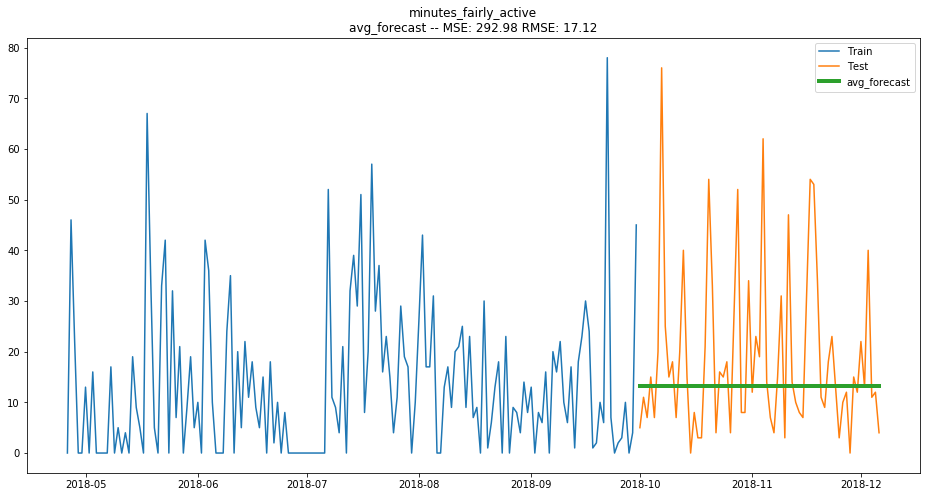

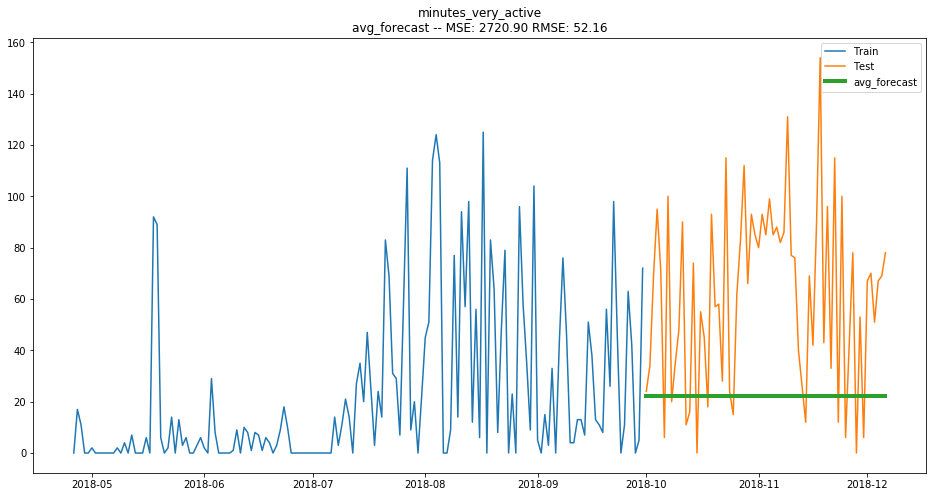

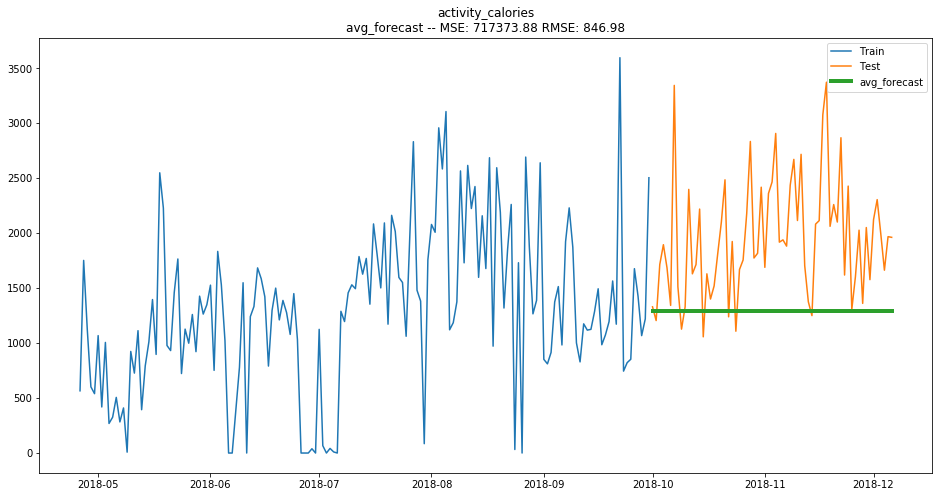

In [48]:
for col in train.columns:
    _ = ts_simple_average(train[col], test[col])

### Moving Average

In [49]:
def ts_moving_average(train, test, periods):
    yhat = pd.DataFrame(dict(actual=test))
    for p in periods:
        yhat[f"moving_avg_forecast_{p}"] = (
            train.rolling(p).mean().iloc[-1]
        )

    forecasts = [yhat[f"moving_avg_forecast_{p}"] for p in periods]

    plot_and_eval(train, test, forecasts, test, linewidth=2)

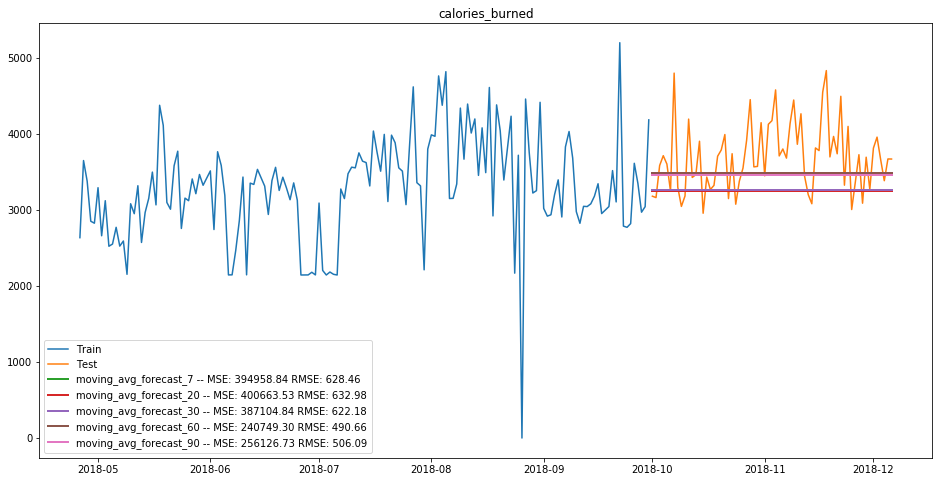

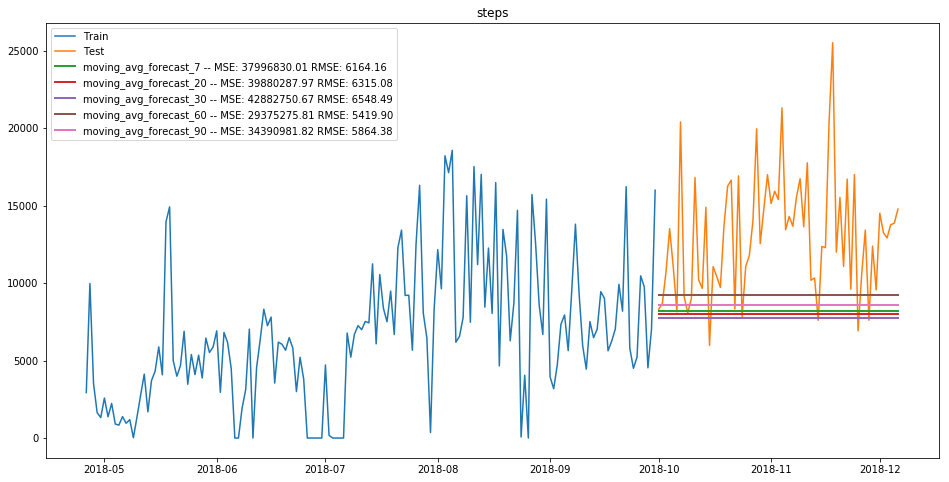

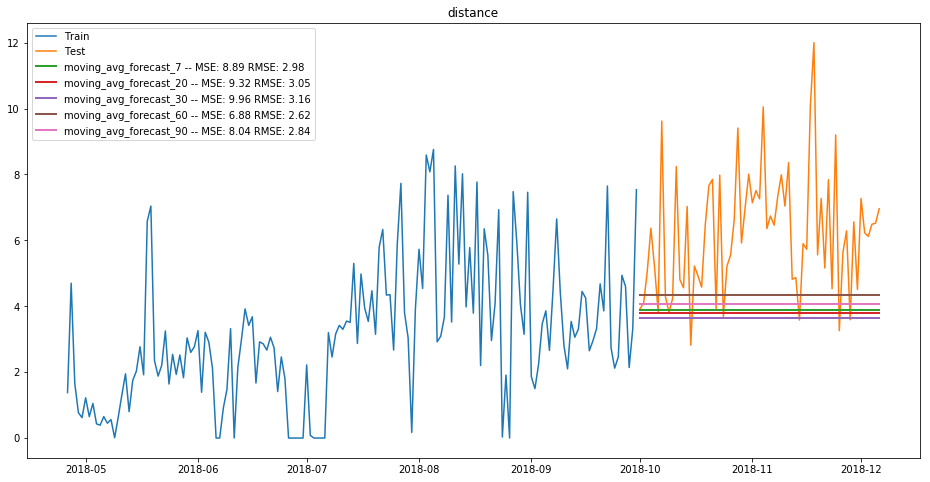

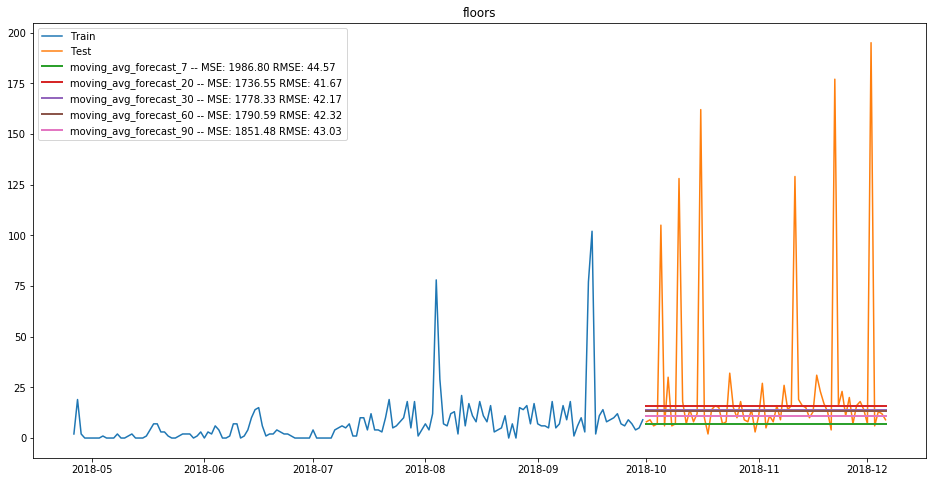

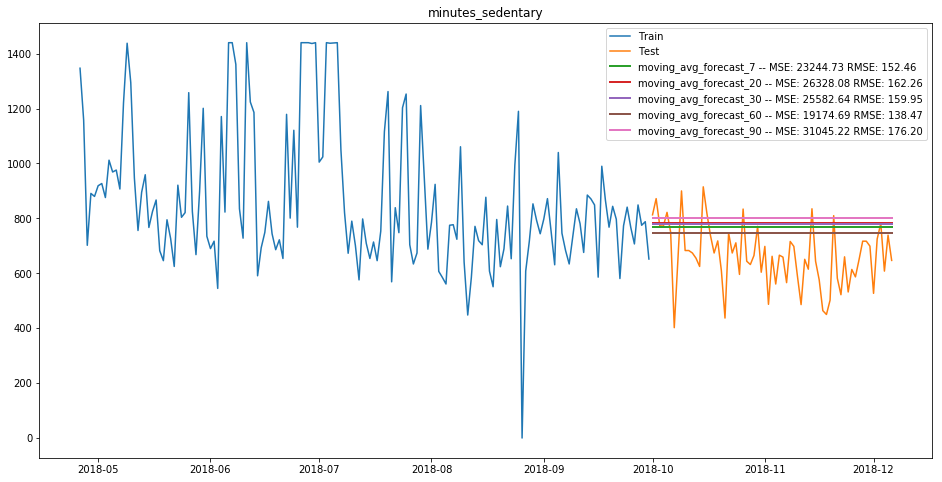

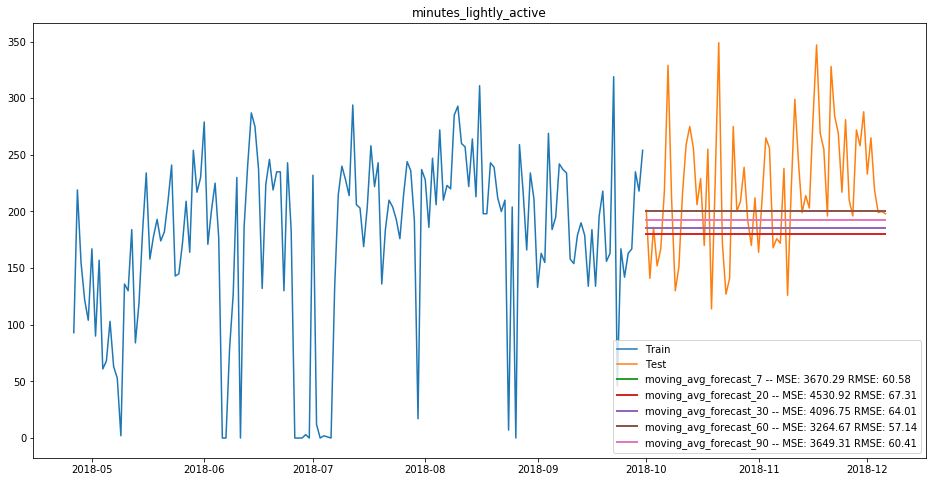

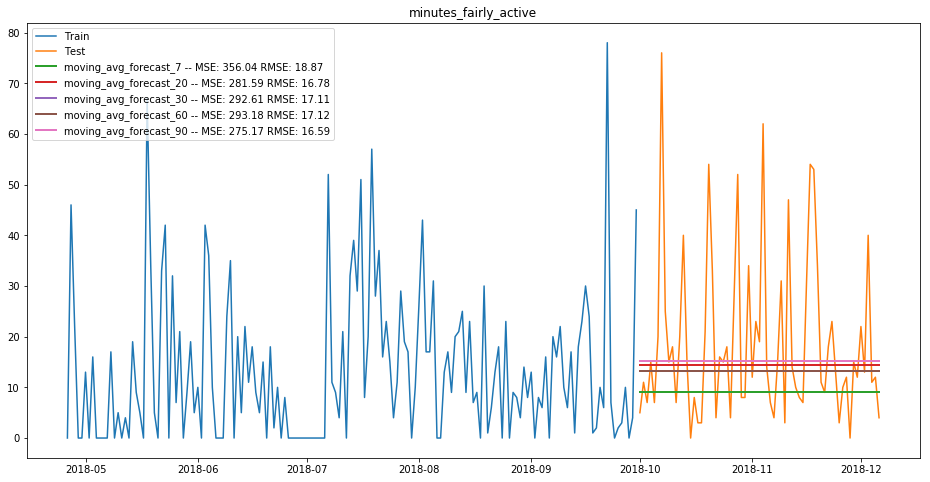

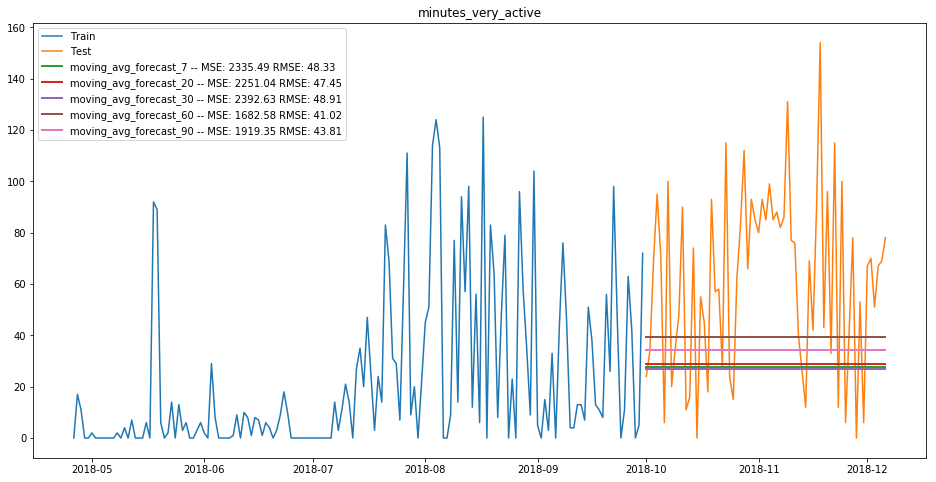

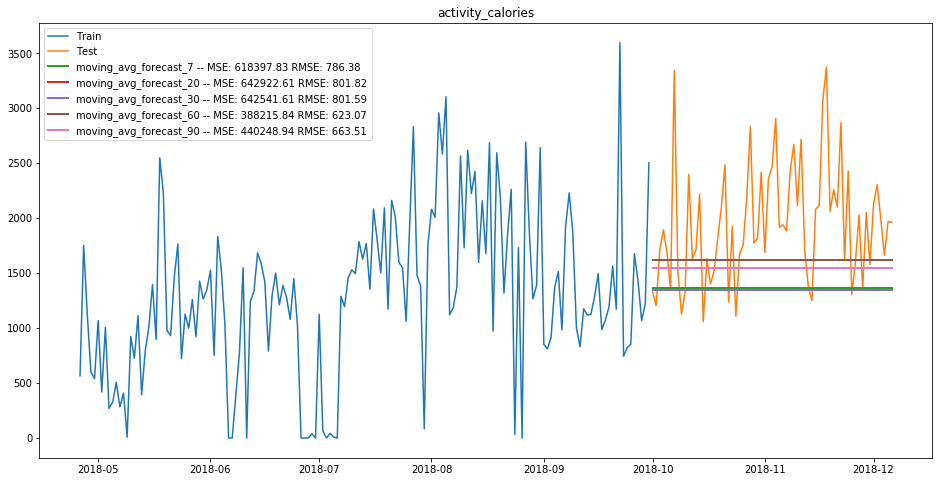

In [50]:
period_vals = [7, 20, 30, 60, 90]
for col in train.columns:
    ts_moving_average(train[col], test[col], period_vals)

### Holt's Linear Trend

In [51]:
def ts_holt(train, test, **kwargs):
    yhat = pd.DataFrame(dict(actual=test))
    sm.tsa.seasonal_decompose(train).plot()
    result = sm.tsa.stattools.adfuller(train)
    plt.show()
    
    holt = Holt(train).fit(**kwargs)
    
    yhat["holt_linear"] = holt.forecast(test.shape[0])
    
    plot_and_eval(train, test, yhat.holt_linear, test)
    
    return holt

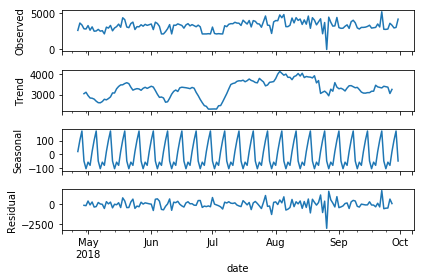

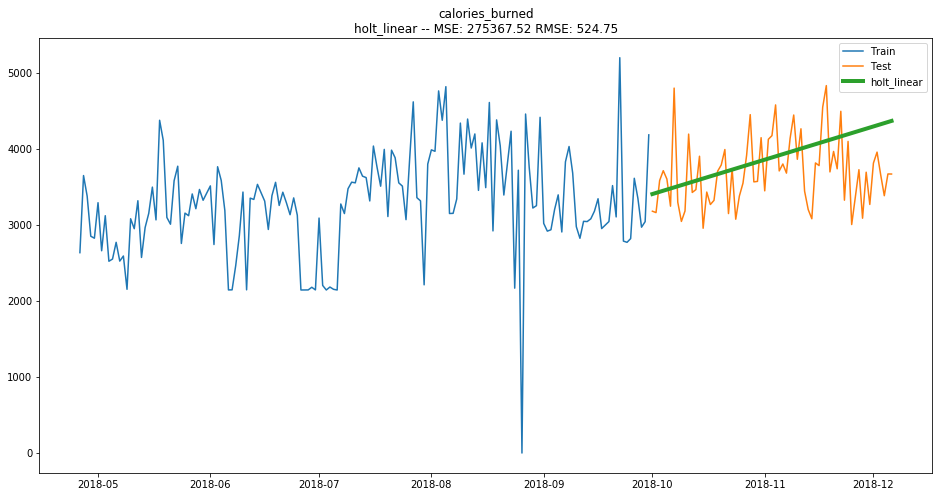

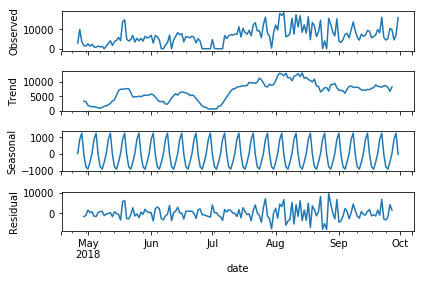

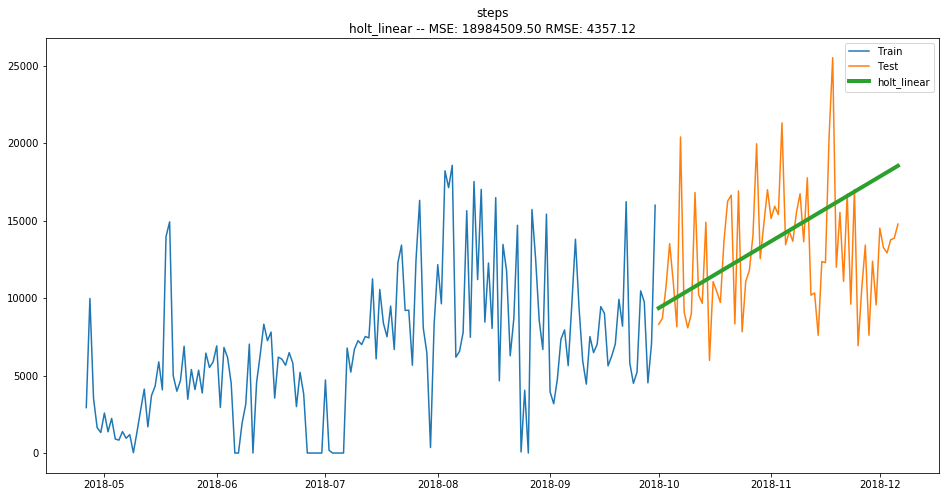

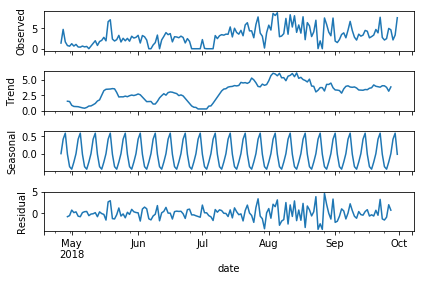

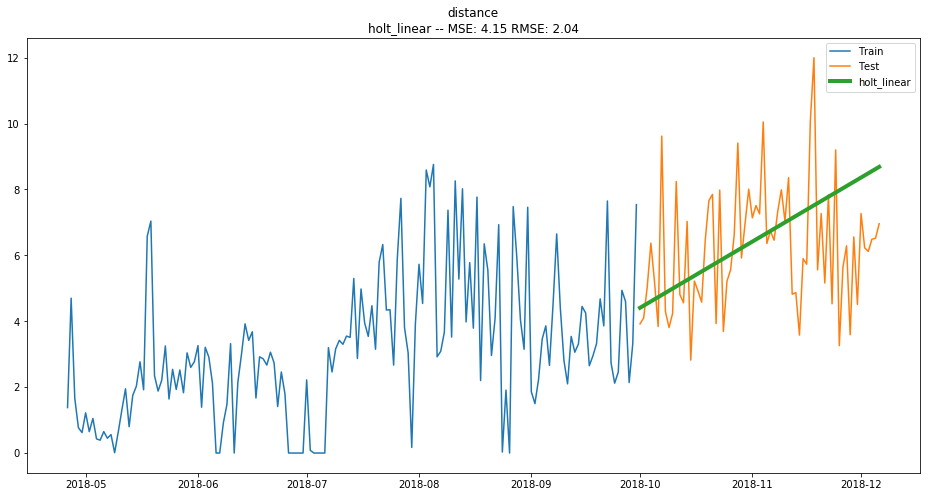

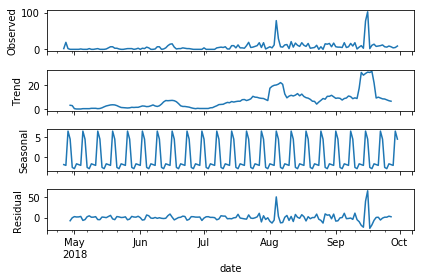

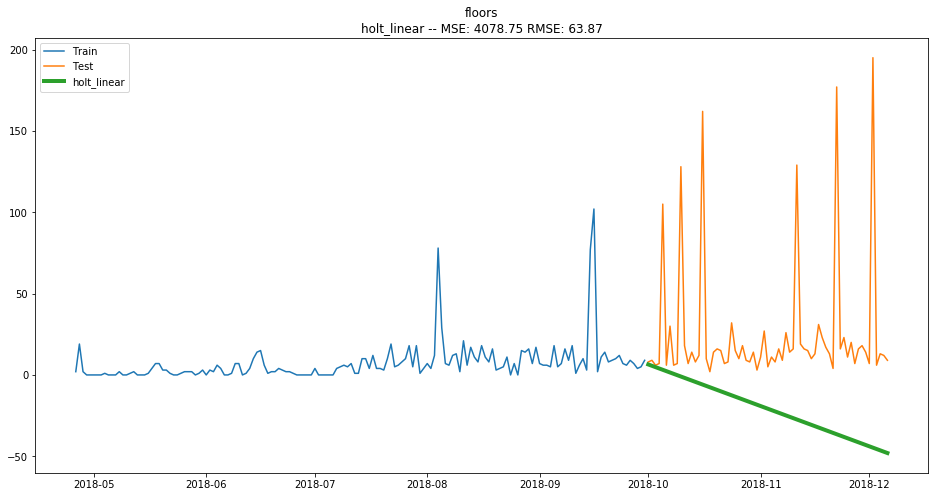

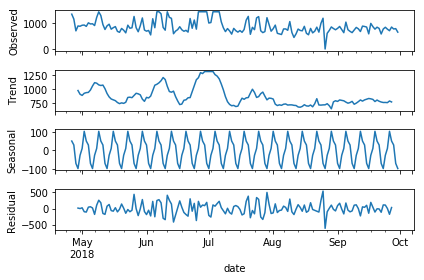

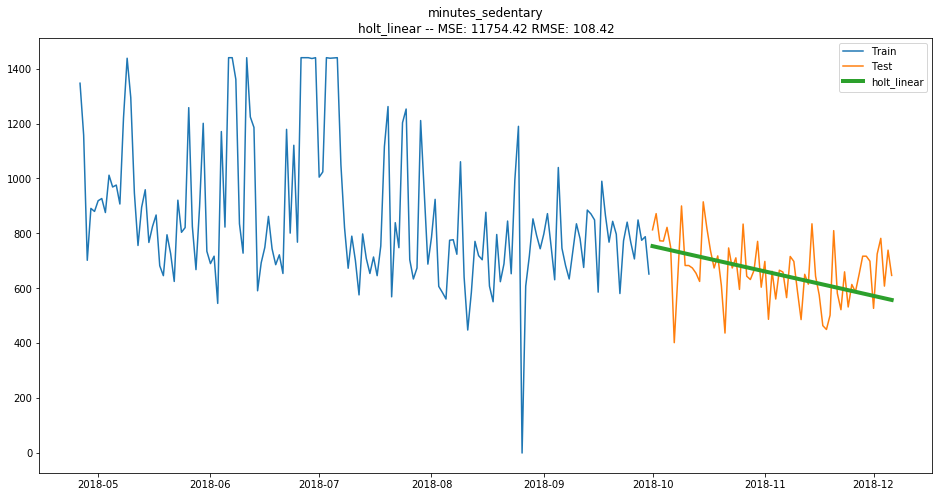

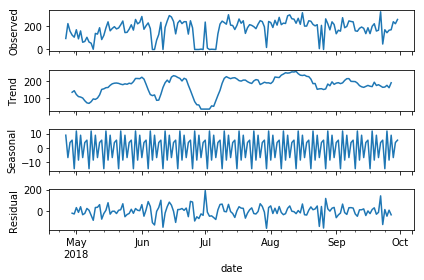

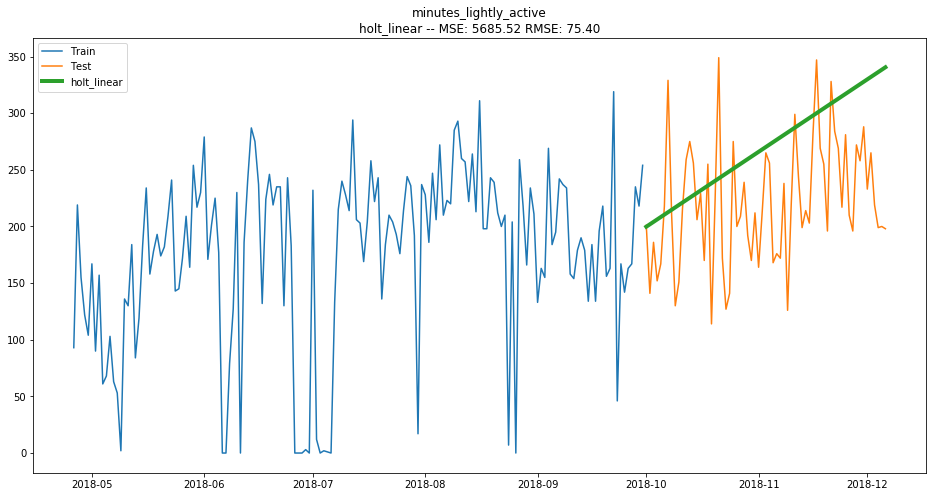

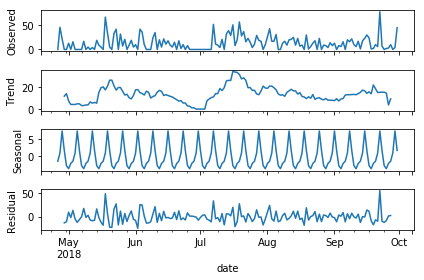

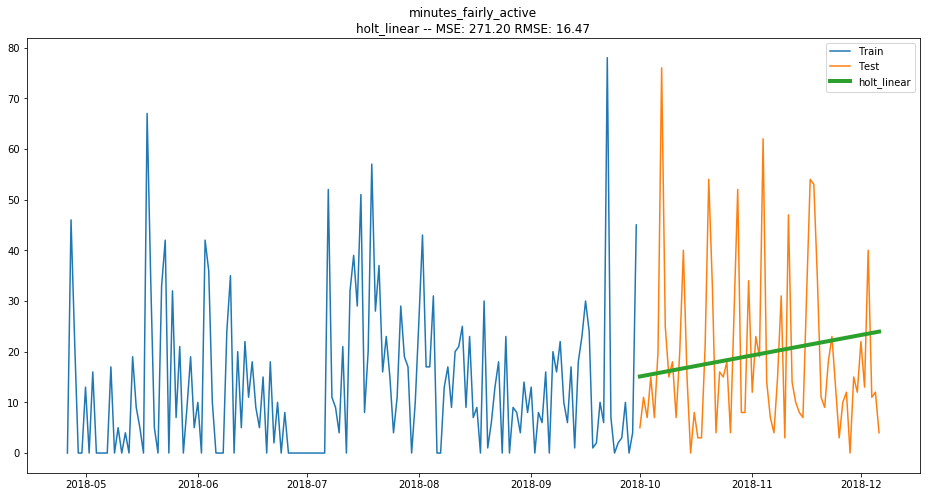

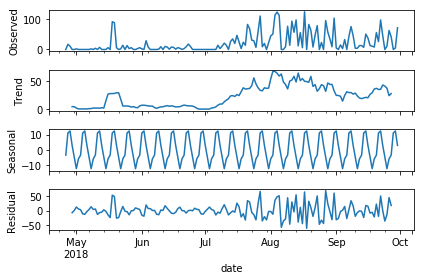

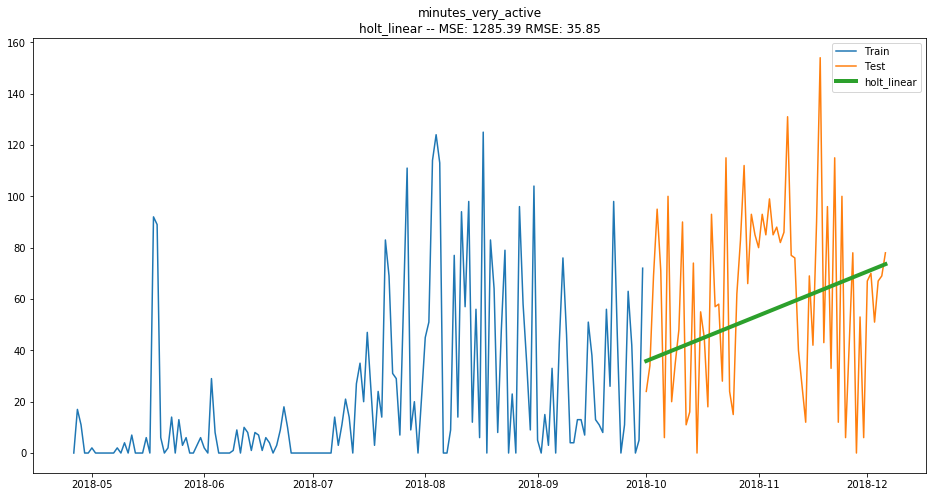

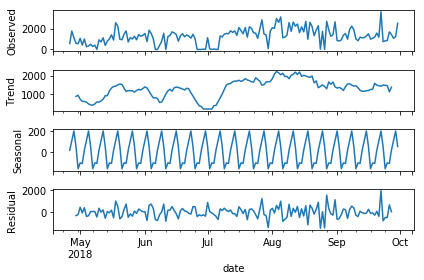

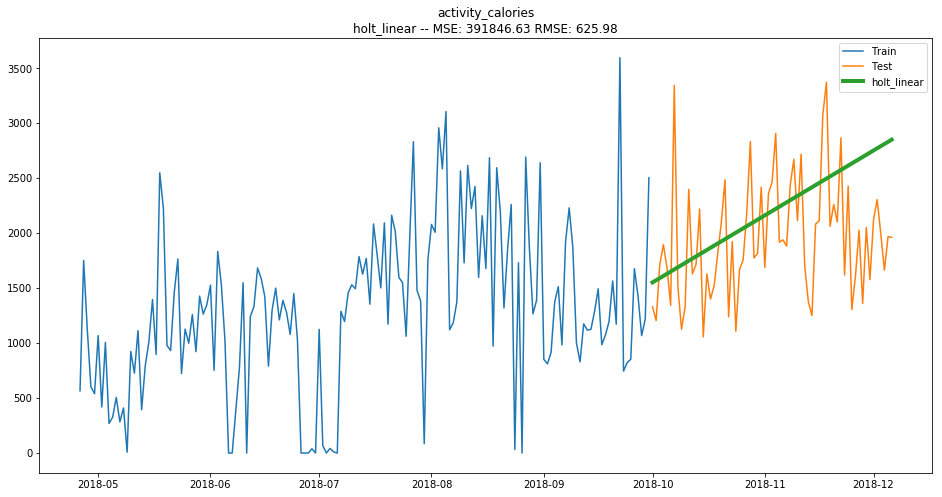

In [52]:
for col in train.columns:
    ts_holt(train[col], test[col], smoothing_level=0.2, smoothing_slope=0.1)

#### The Best Model

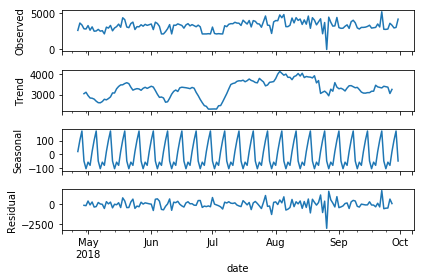

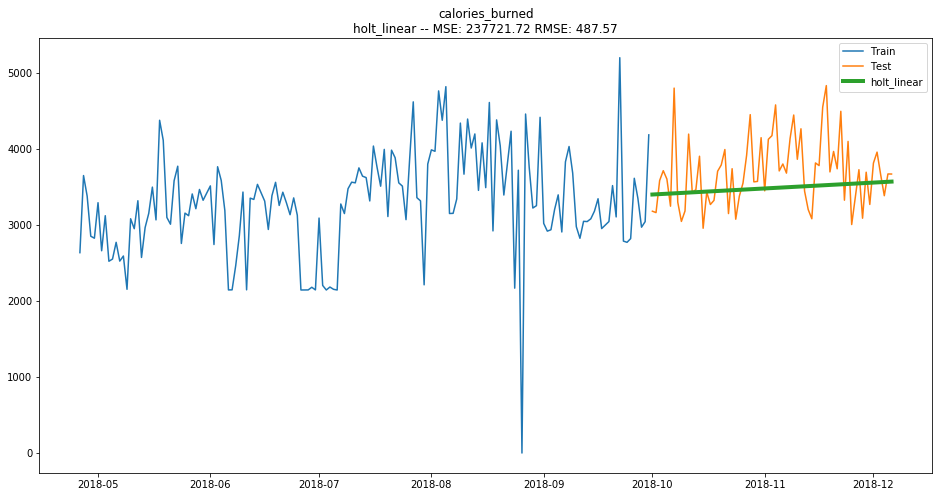

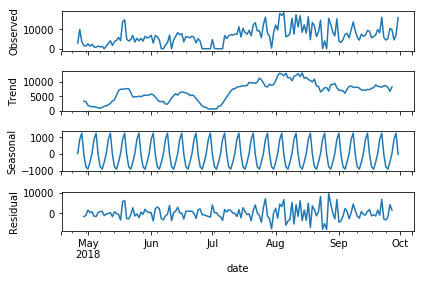

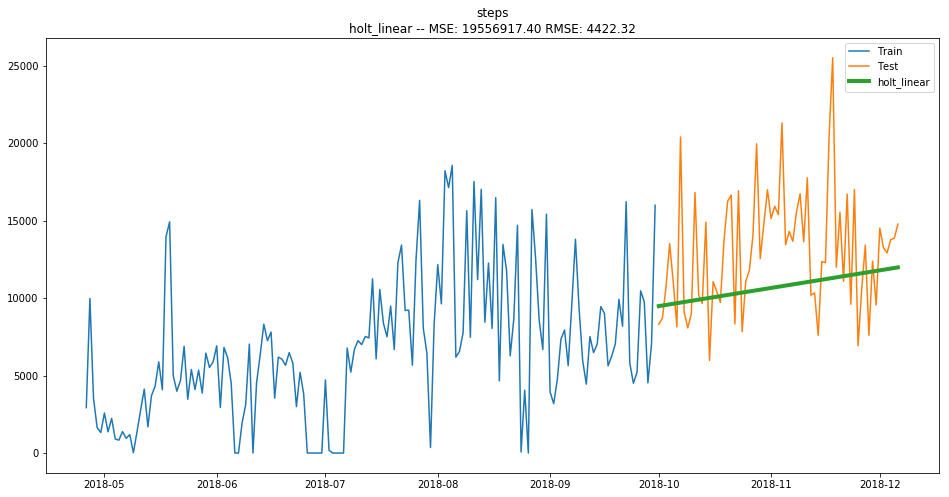

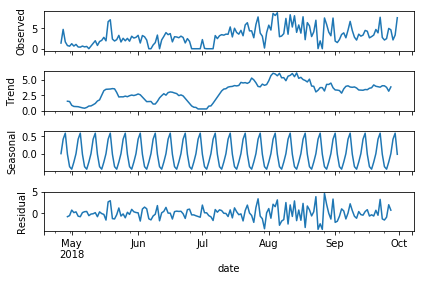

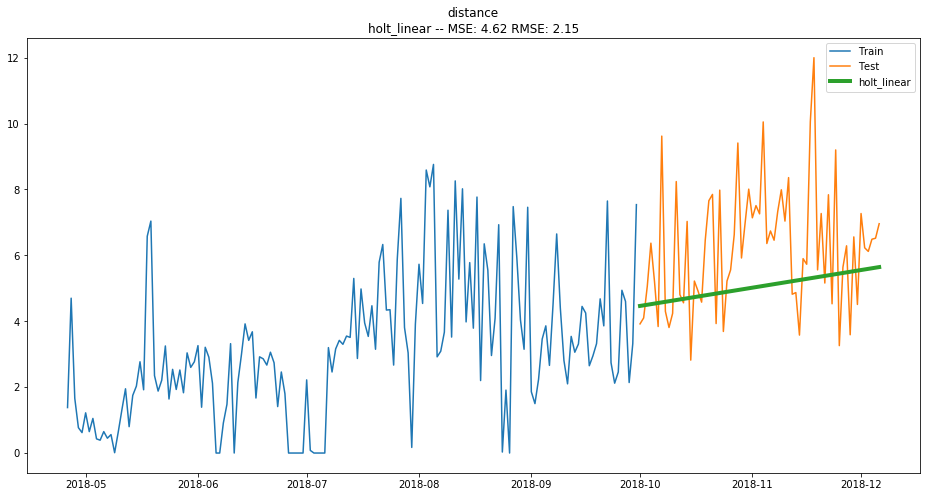

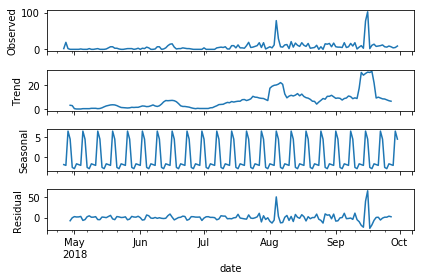

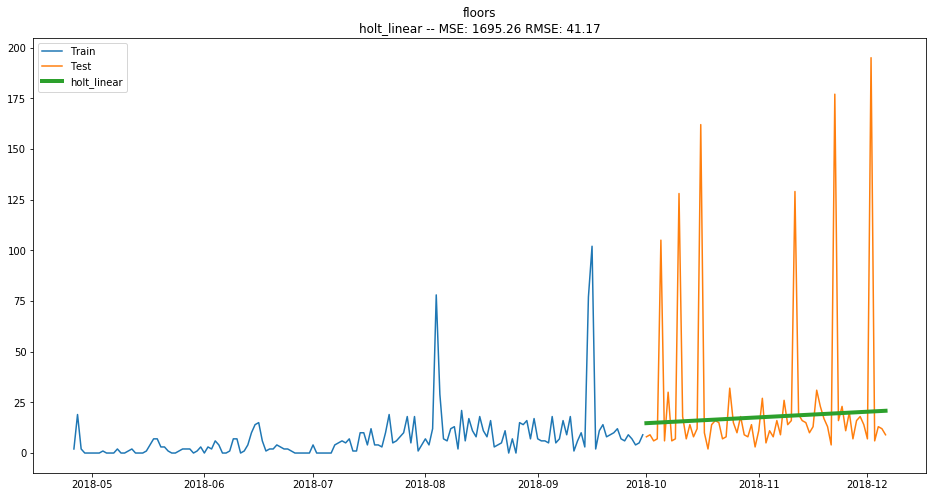

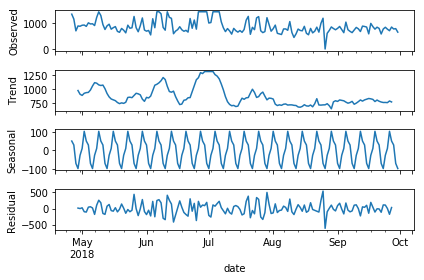

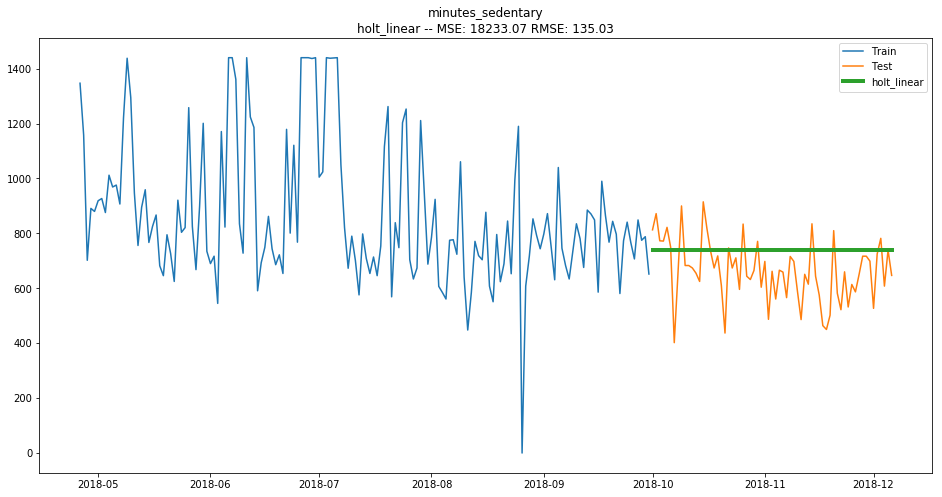

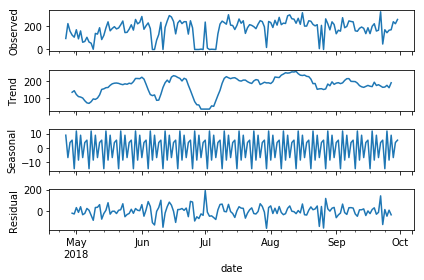

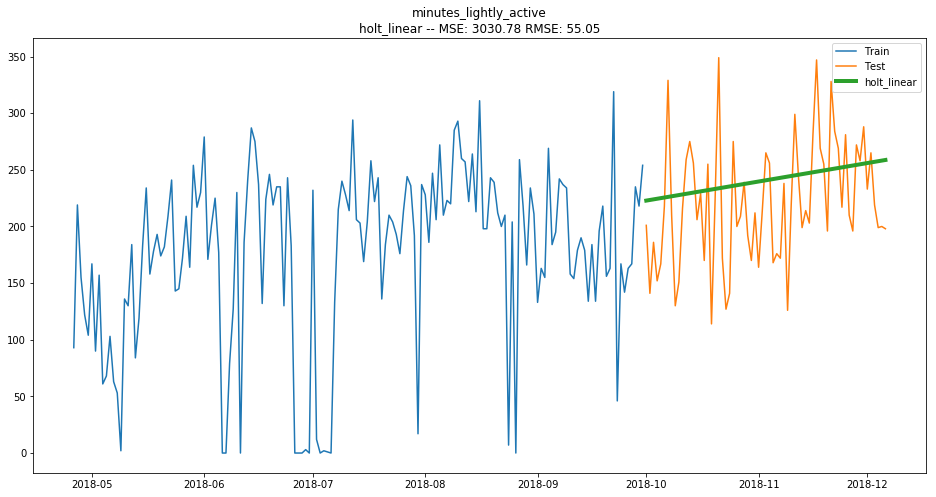

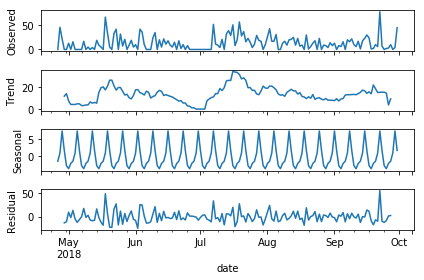

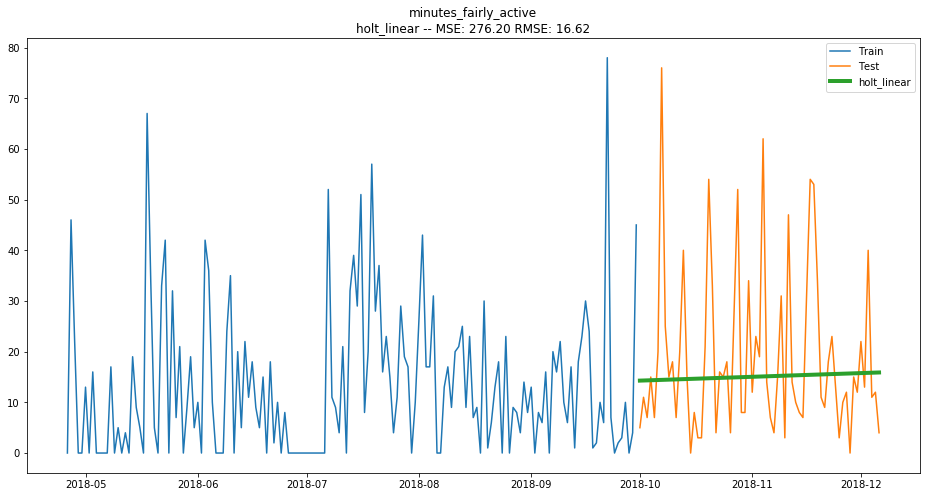

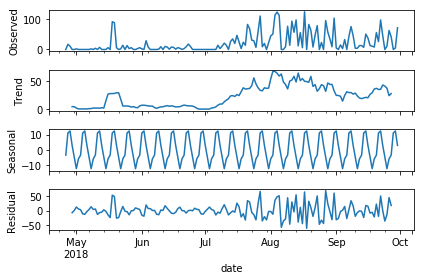

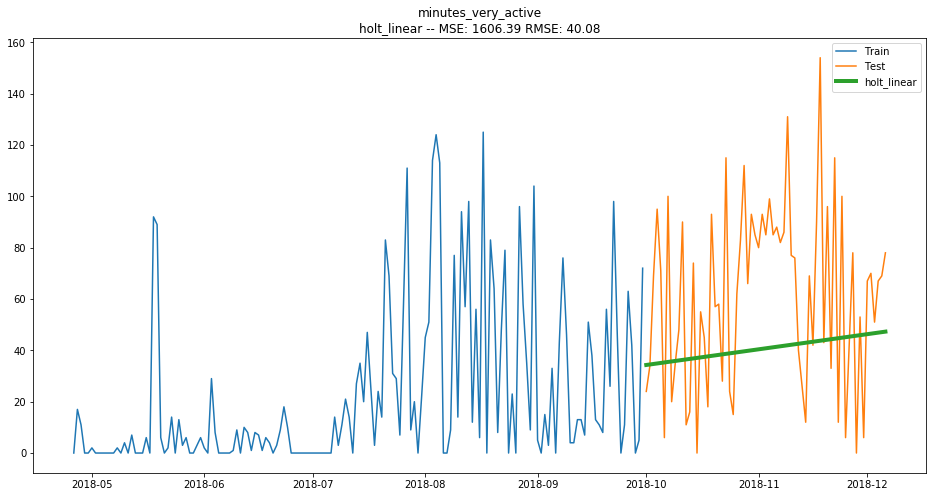

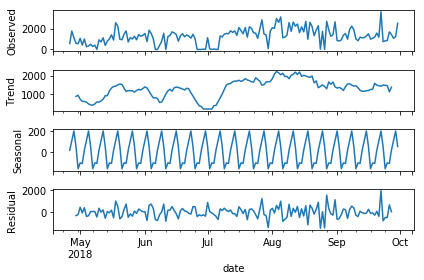

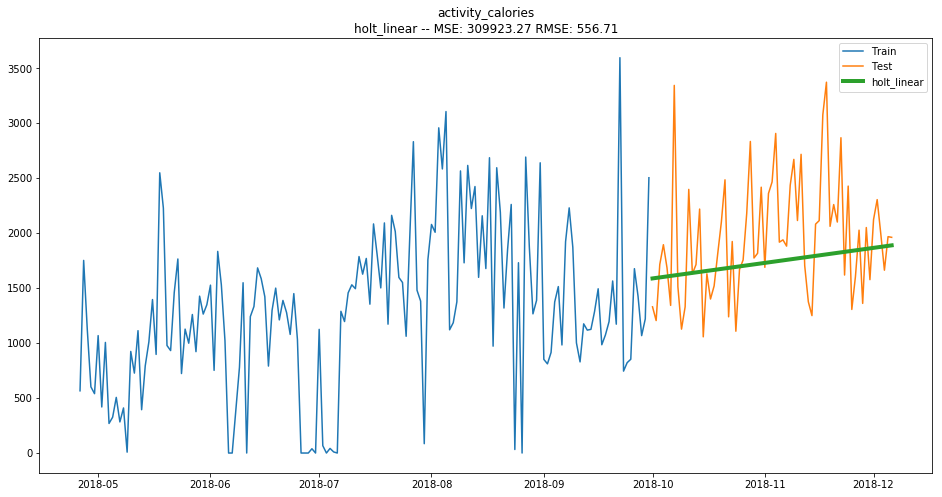

In [53]:
for col in train.columns:
    model = ts_holt(train[col], test[col])
    df_forecast[col] = model.predict(df_forecast.index[0], df_forecast.index[-1])

In [54]:
df_forecast.round(2).to_csv("missing_weeks_forecast.csv")

### Prophet

In [55]:
def ts_prophet(series, periods, horizon, cap=None, floor=None, **kwargs):
    df = pd.DataFrame()
    df["y"] = series
    df["ds"] = series.index
    if cap is not None:
        df["cap"] = cap
    if floor is not None:
        df["floor"] = floor
    
    plt.figure(figsize=(16, 6))
    plt.title(series.name)
    sns.lineplot(df.ds, df.y)
    plt.show()
    
    m = Prophet(**kwargs)
    Prophet()
    m.fit(df)
    
    future = m.make_future_dataframe(periods)
    if cap is not None:
        future["cap"] = cap
    if floor is not None:
        future["floor"] = floor
    
    forecast = m.predict(future)
    
    fig1 = m.plot(forecast)
    plt.show()
    fig2 = m.plot_components(forecast)
    plt.show()
    
    df_cv = cross_validation(m, horizon)
    
    df_p = performance_metrics(df_cv, rolling_window=1)
    
    fig3 = plot_cross_validation_metric(df_cv, metric="rmse")
    plt.show()
    
    return forecast, df_cv, df_p

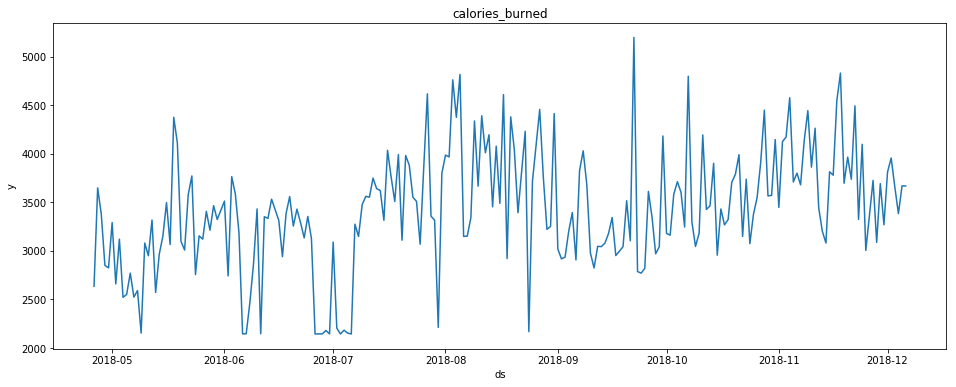

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/usr/local/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


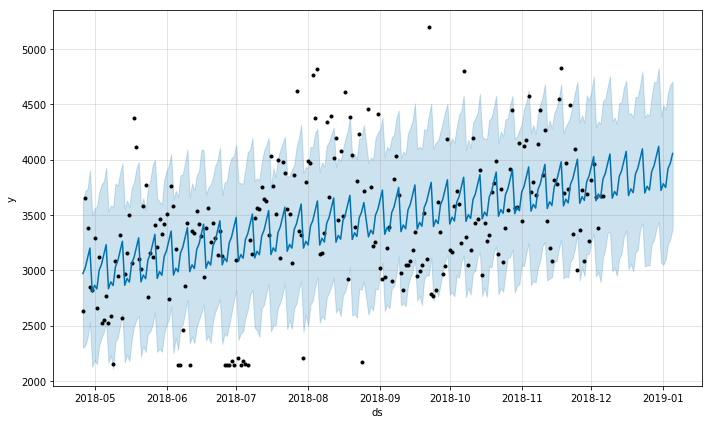

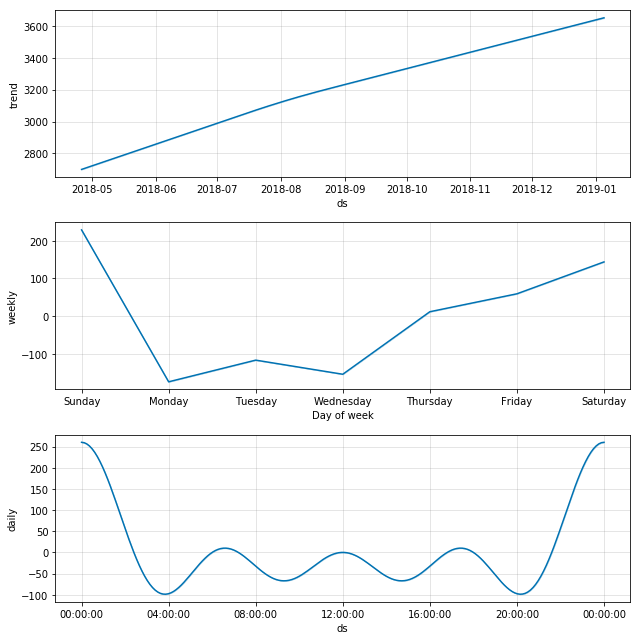

INFO:fbprophet:Making 25 forecasts with cutoffs between 2018-06-07 00:00:00 and 2018-11-22 00:00:00


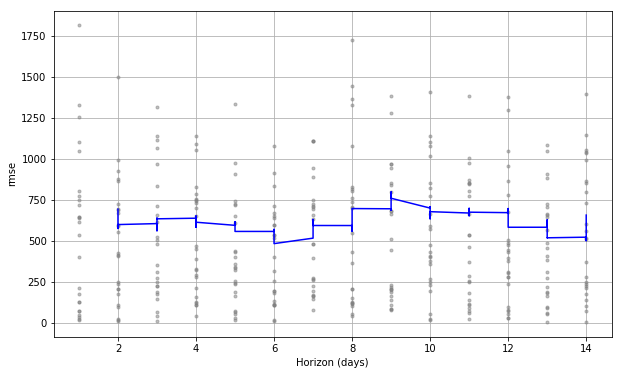

    horizon            mse        rmse         mae      mape  coverage
347 14 days  402175.607762  634.173169  507.293059  0.156487   0.70977


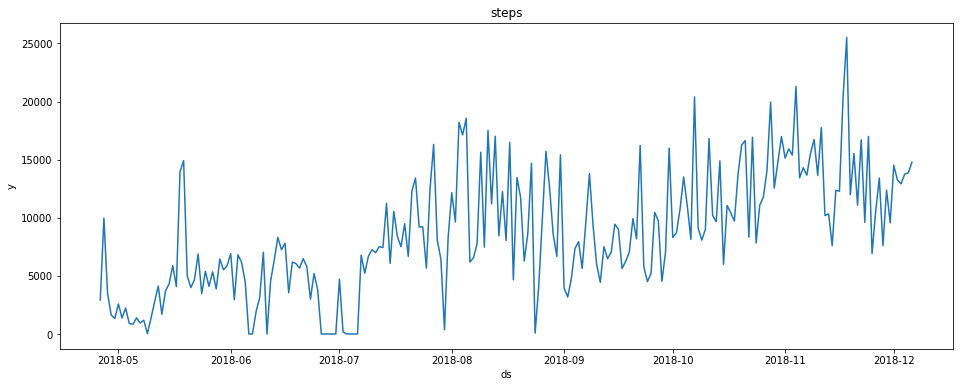

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


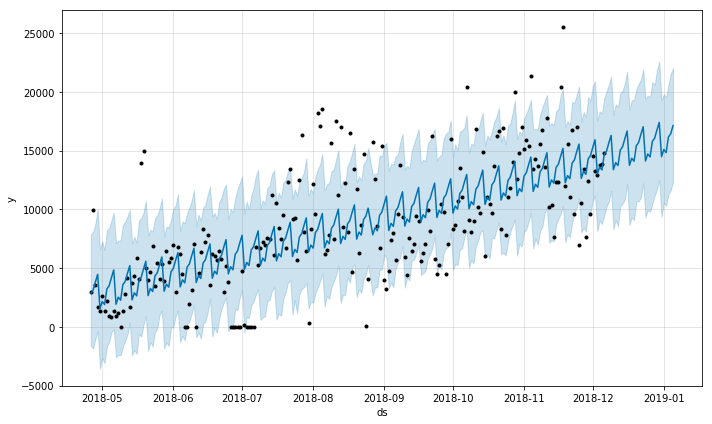

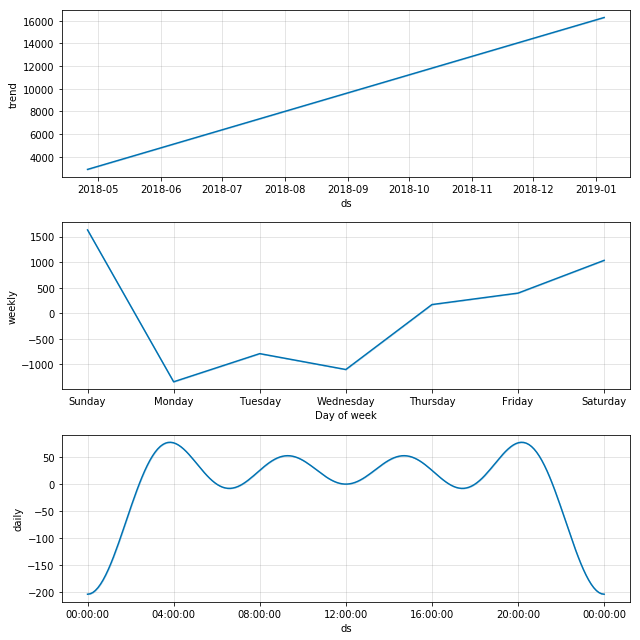

INFO:fbprophet:Making 25 forecasts with cutoffs between 2018-06-07 00:00:00 and 2018-11-22 00:00:00


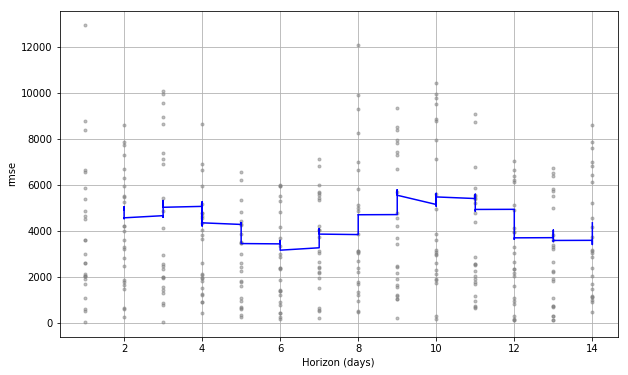

    horizon           mse         rmse          mae  mape  coverage
347 14 days  2.048990e+07  4526.577607  3699.992163   inf  0.658046


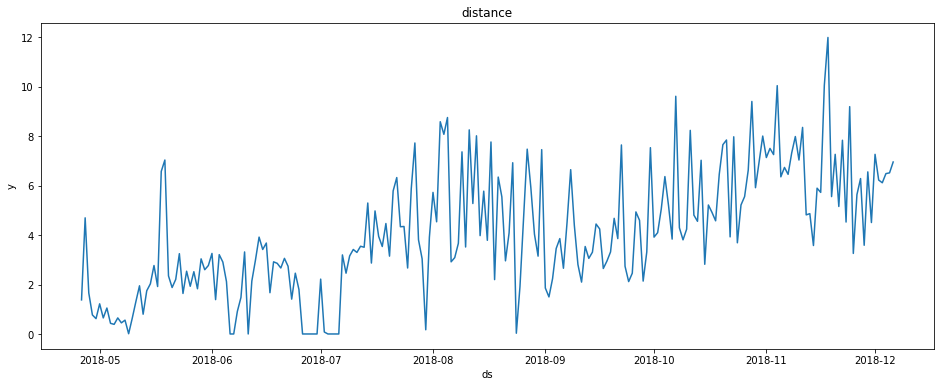

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


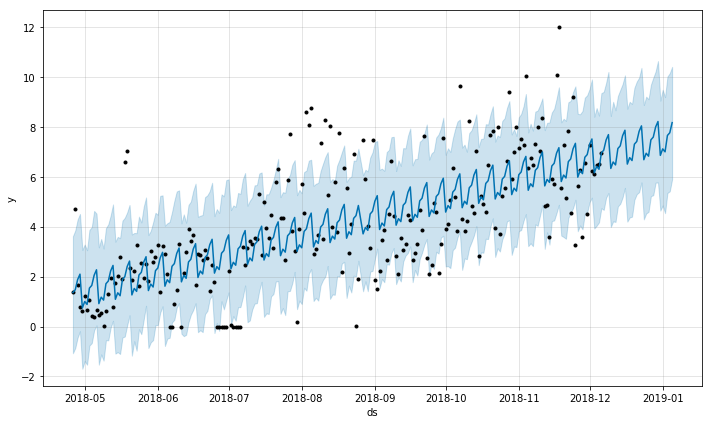

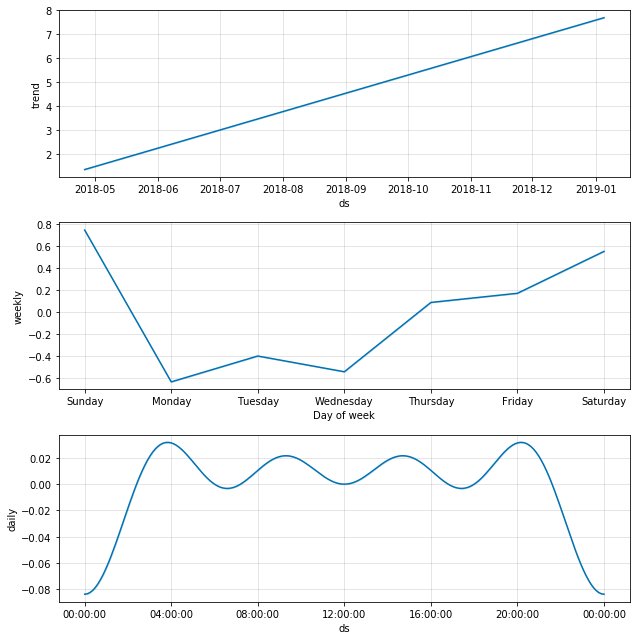

INFO:fbprophet:Making 25 forecasts with cutoffs between 2018-06-07 00:00:00 and 2018-11-22 00:00:00


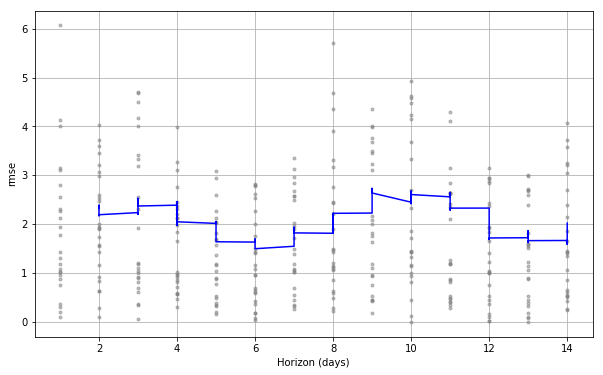

    horizon       mse      rmse      mae  mape  coverage
347 14 days  4.543283  2.131498  1.74079   inf  0.652299


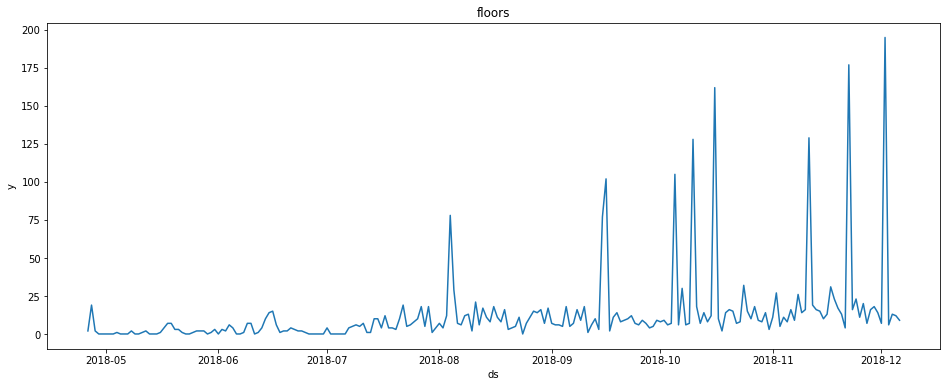

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


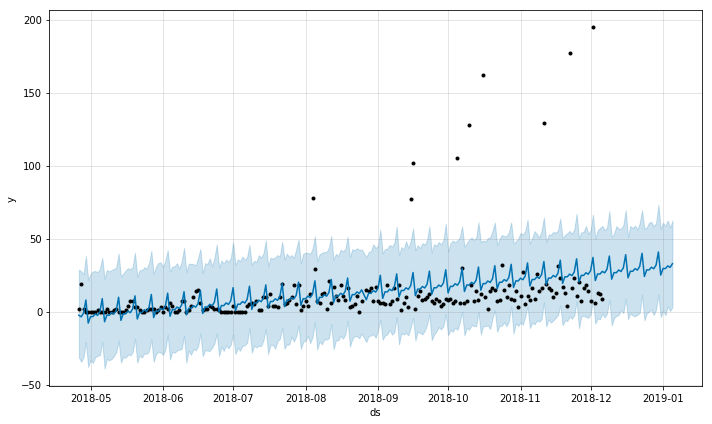

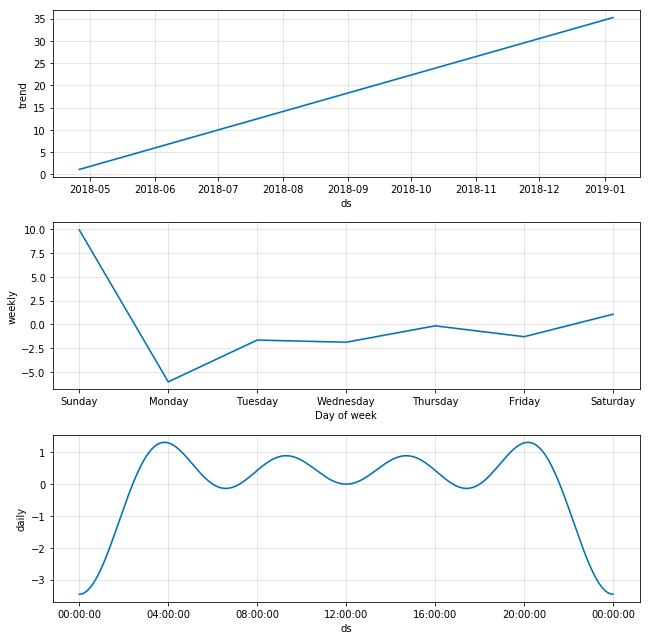

INFO:fbprophet:Making 25 forecasts with cutoffs between 2018-06-07 00:00:00 and 2018-11-22 00:00:00


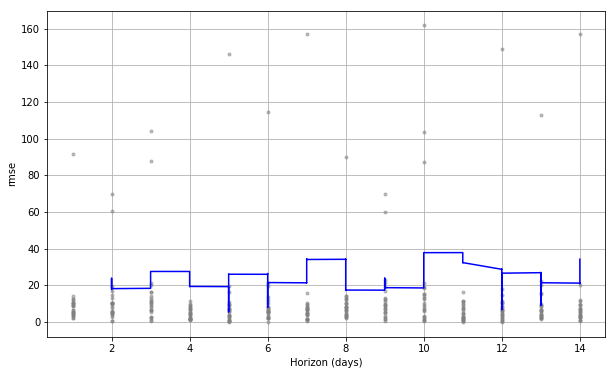

    horizon         mse       rmse        mae  mape  coverage
347 14 days  689.312475  26.254761  11.955356   inf  0.758621


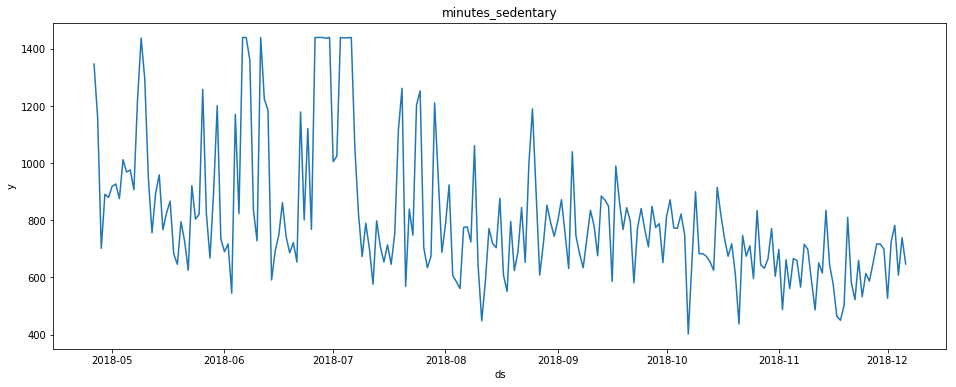

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


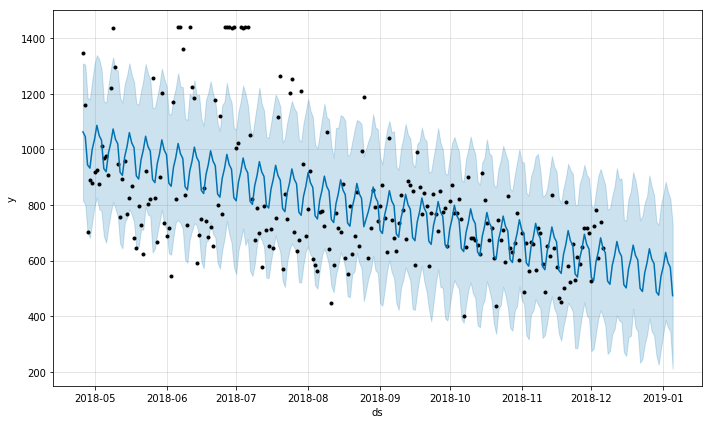

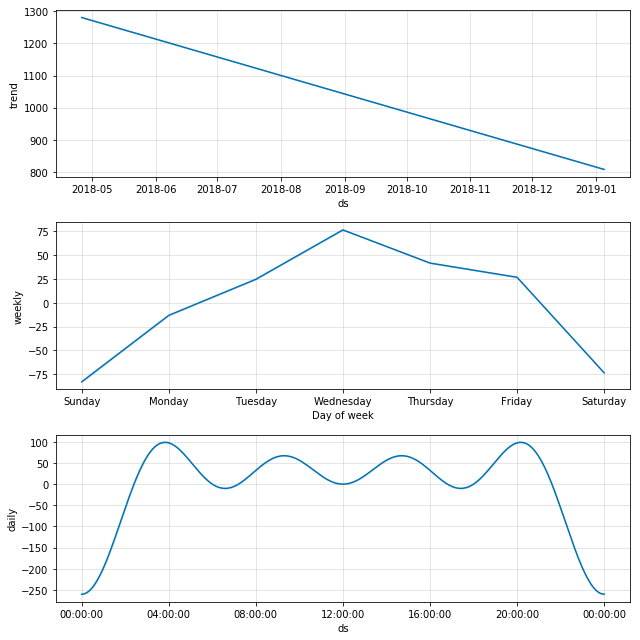

INFO:fbprophet:Making 25 forecasts with cutoffs between 2018-06-07 00:00:00 and 2018-11-22 00:00:00


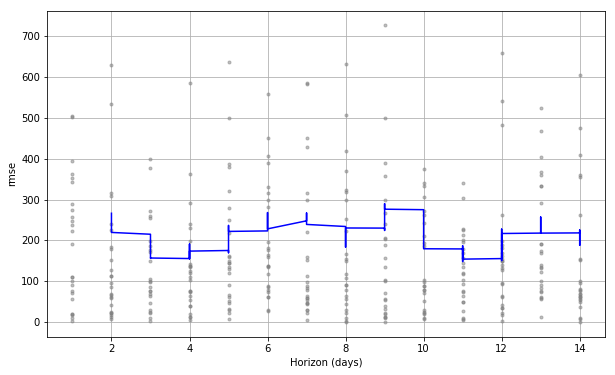

    horizon           mse        rmse         mae      mape  coverage
347 14 days  49060.912918  221.496982  164.358765  0.209764  0.841954


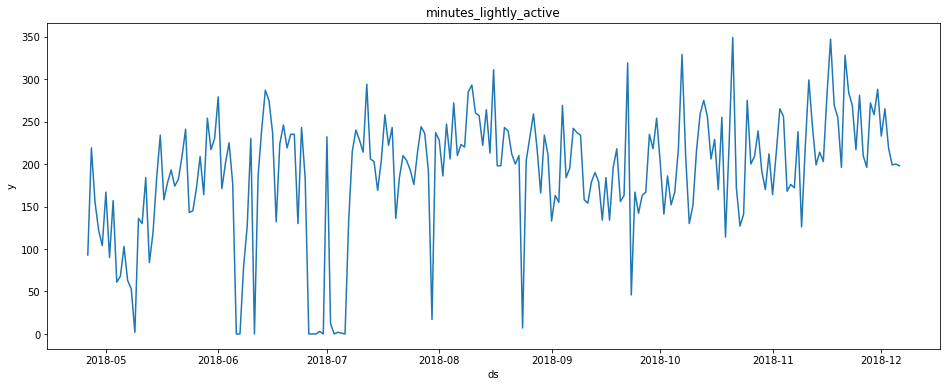

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


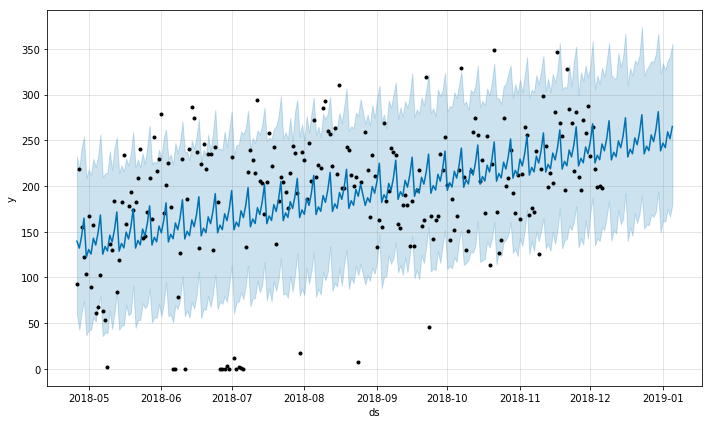

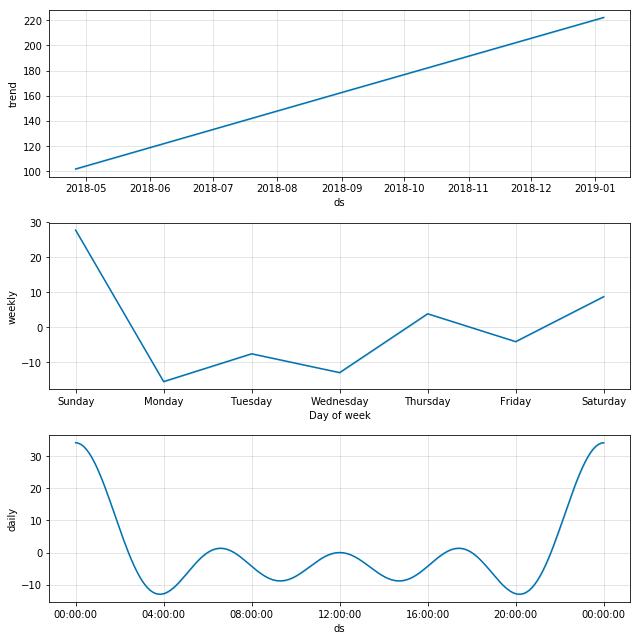

INFO:fbprophet:Making 25 forecasts with cutoffs between 2018-06-07 00:00:00 and 2018-11-22 00:00:00


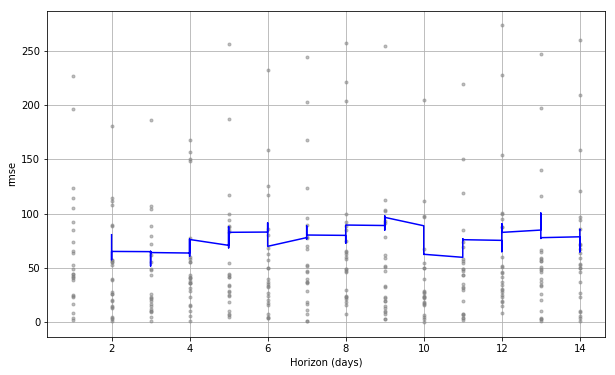

    horizon          mse       rmse       mae  mape  coverage
347 14 days  6390.856813  79.942835  57.92229   inf  0.841954


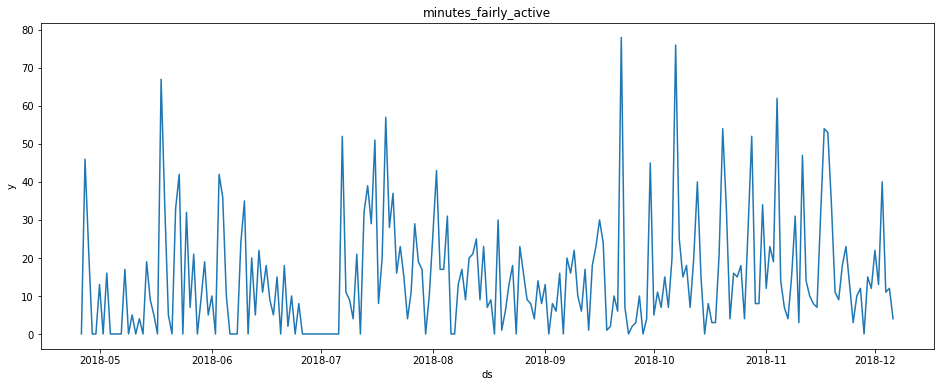

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


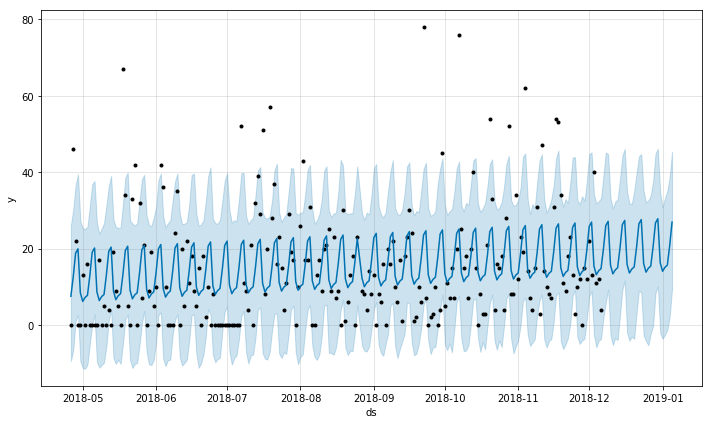

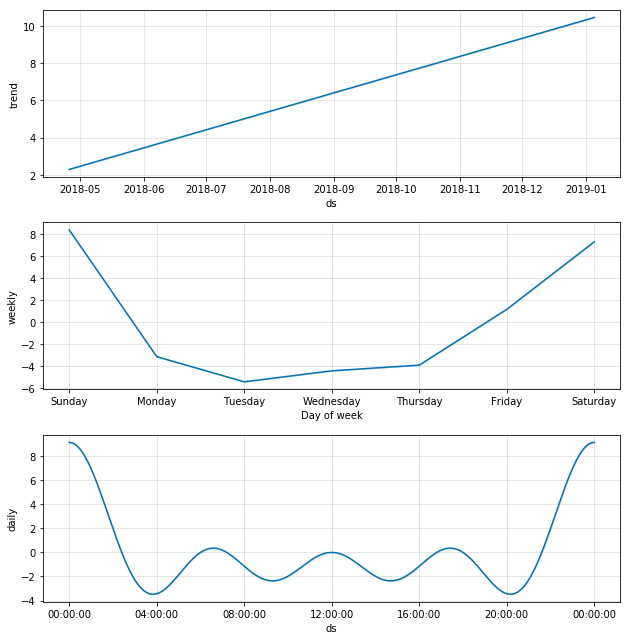

INFO:fbprophet:Making 25 forecasts with cutoffs between 2018-06-07 00:00:00 and 2018-11-22 00:00:00


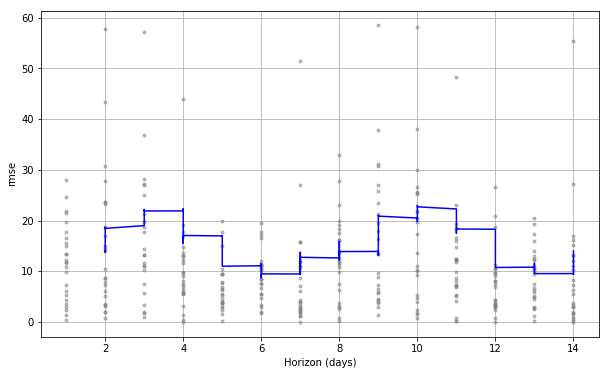

    horizon        mse       rmse        mae  mape  coverage
347 14 days  240.87308  15.520086  11.594088   inf  0.804598


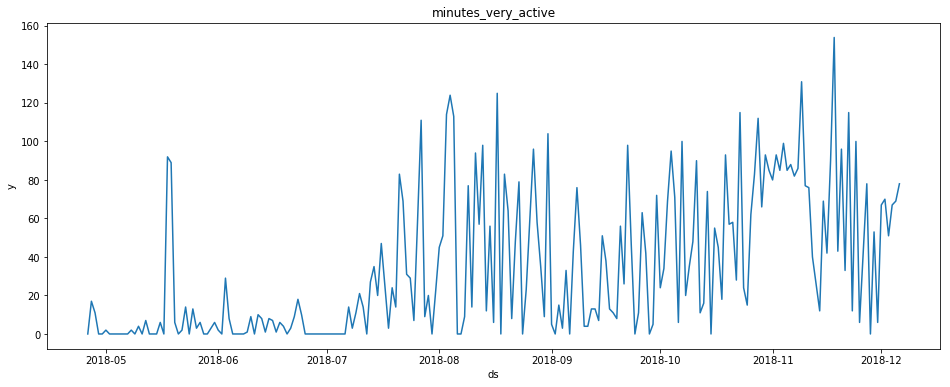

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


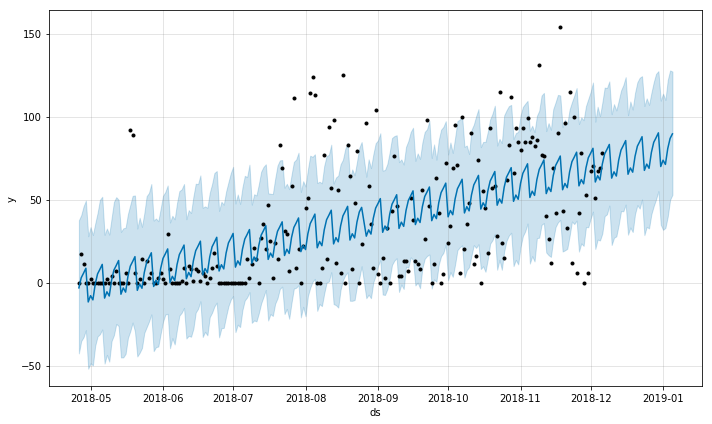

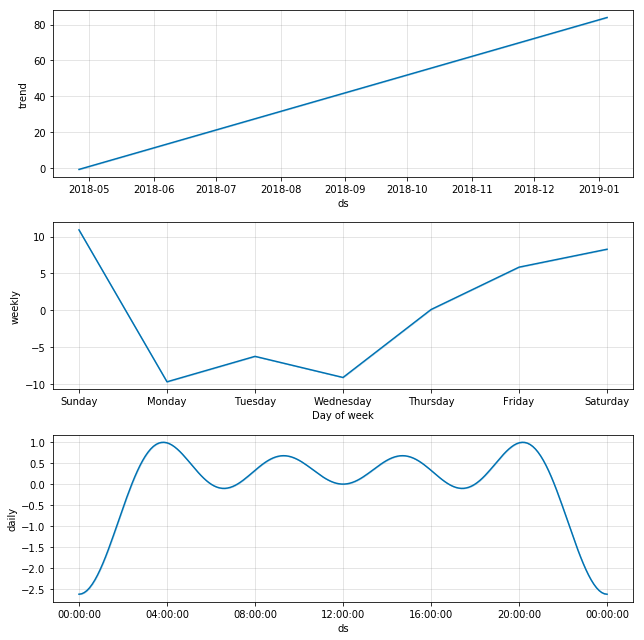

INFO:fbprophet:Making 25 forecasts with cutoffs between 2018-06-07 00:00:00 and 2018-11-22 00:00:00


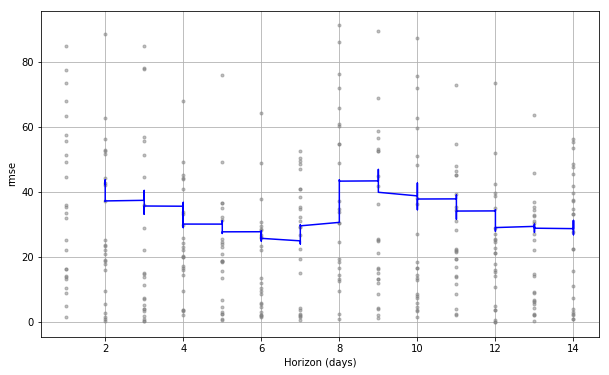

    horizon          mse      rmse        mae  mape  coverage
347 14 days  1197.218851  34.60085  27.141389   inf  0.632184


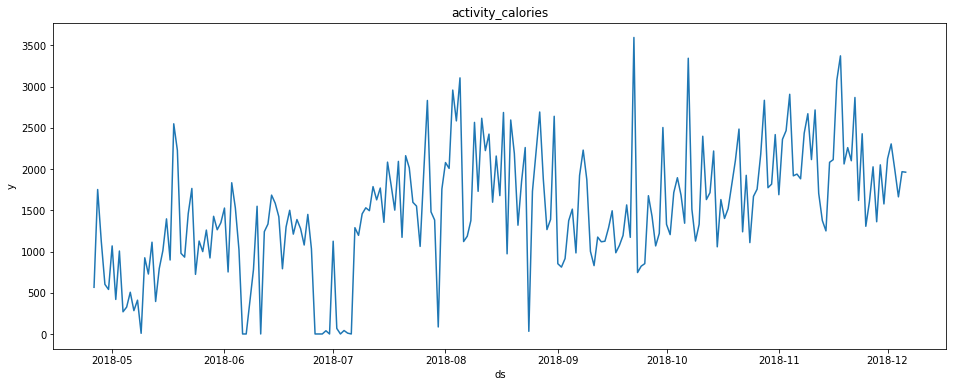

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


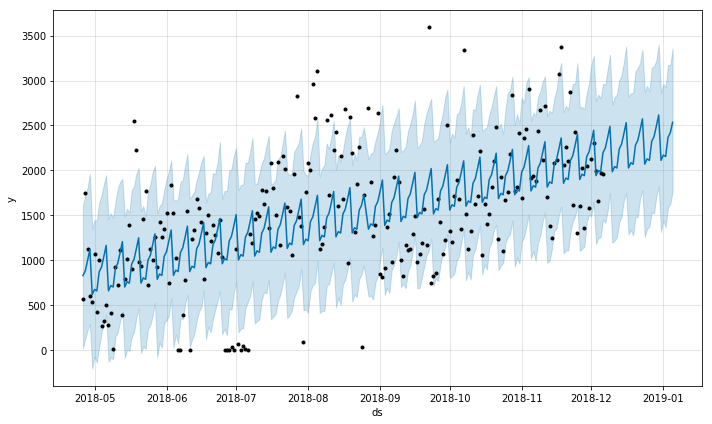

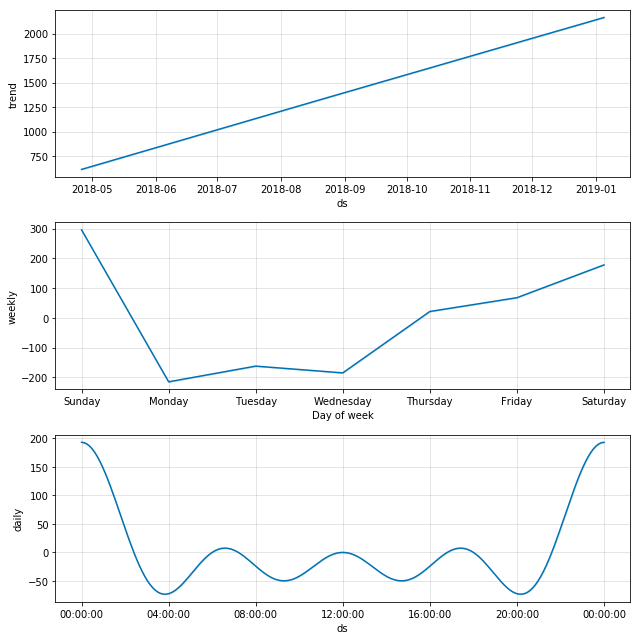

INFO:fbprophet:Making 25 forecasts with cutoffs between 2018-06-07 00:00:00 and 2018-11-22 00:00:00


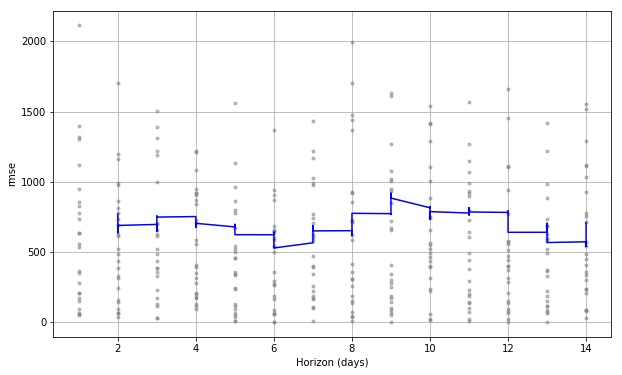

    horizon            mse        rmse         mae  mape  coverage
347 14 days  511554.878653  715.230647  566.704634   inf  0.738506


In [56]:
for col in df.columns:
    _, _, df_p = ts_prophet(df[col], 30, "14 days", daily_seasonality=True, changepoint_range=0.9)
    print(df_p)

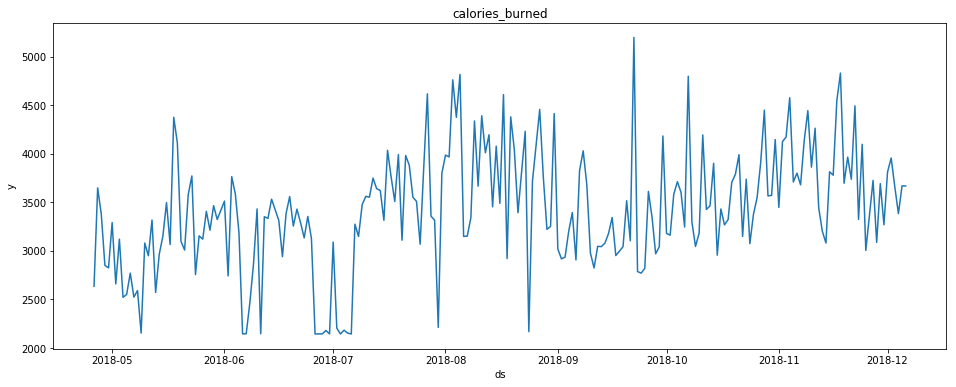

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


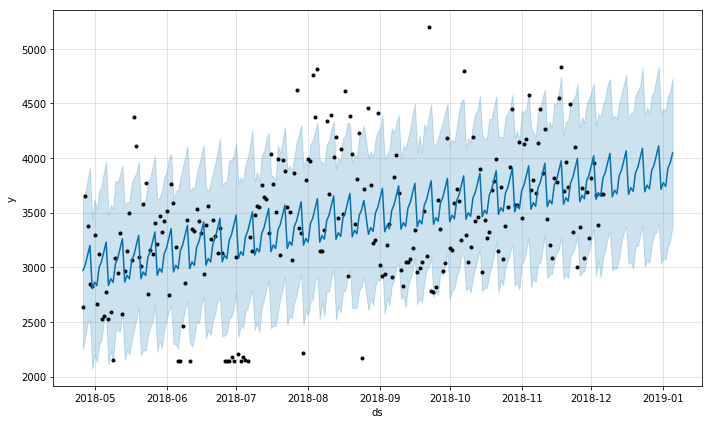

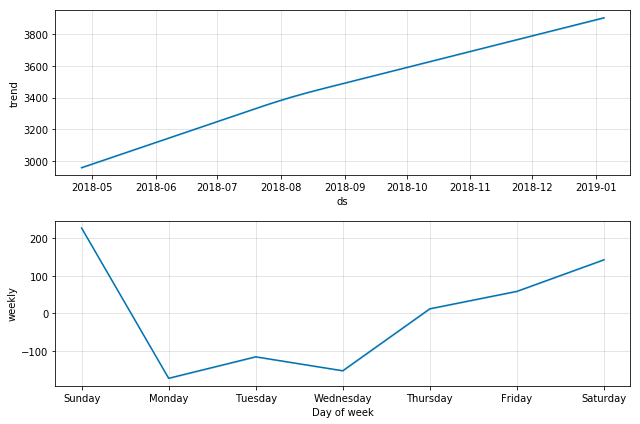

INFO:fbprophet:Making 25 forecasts with cutoffs between 2018-06-07 00:00:00 and 2018-11-22 00:00:00


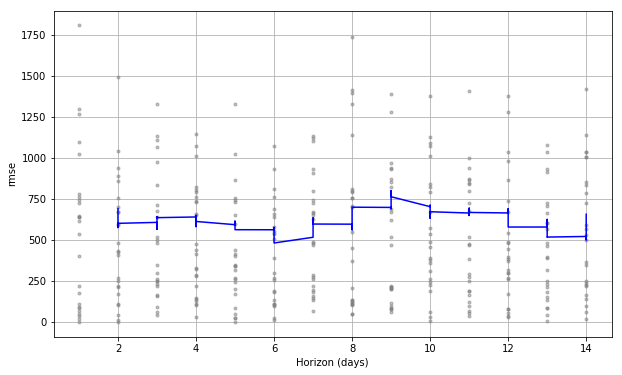

    horizon            mse        rmse         mae      mape  coverage
347 14 days  402796.223755  634.662291  508.382136  0.156799   0.70977


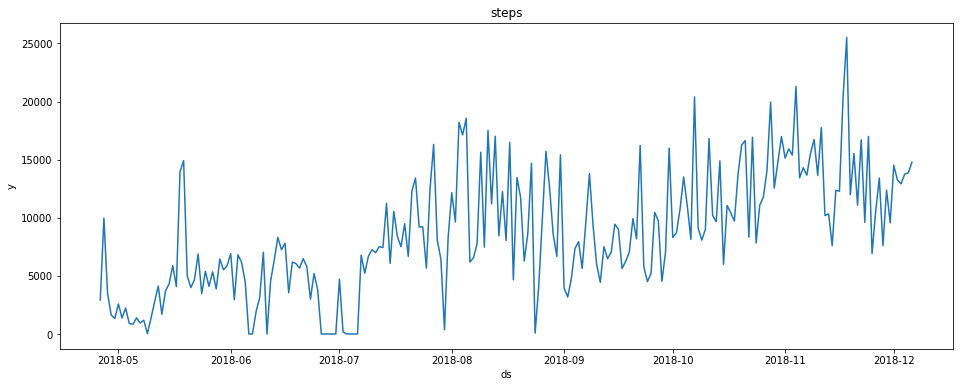

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


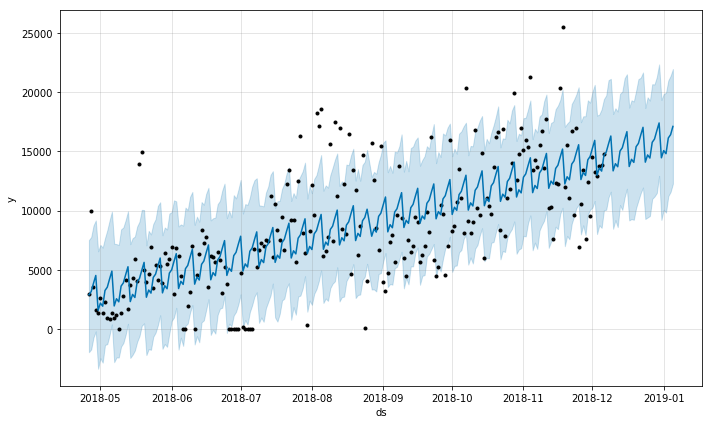

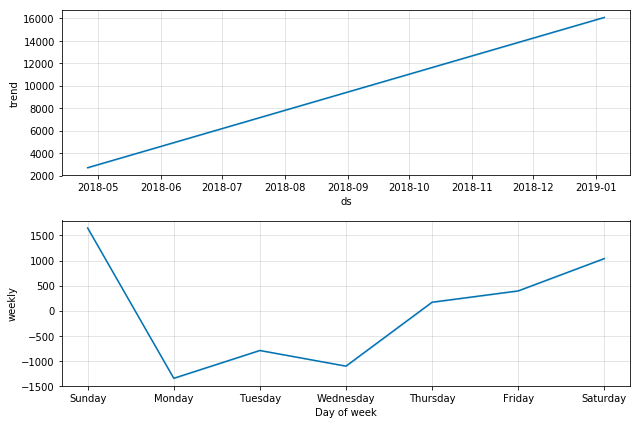

INFO:fbprophet:Making 25 forecasts with cutoffs between 2018-06-07 00:00:00 and 2018-11-22 00:00:00


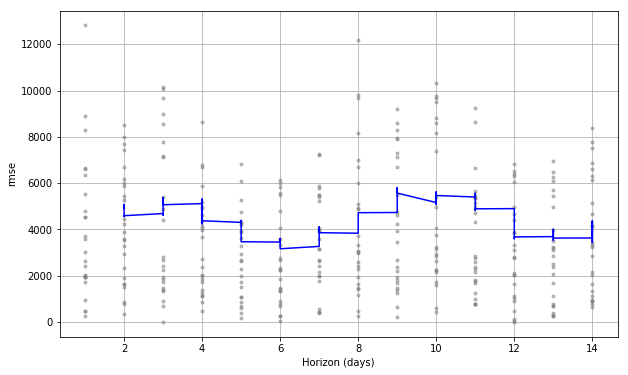

    horizon           mse      rmse          mae  mape  coverage
347 14 days  2.047647e+07  4525.093  3698.677234   inf   0.66092


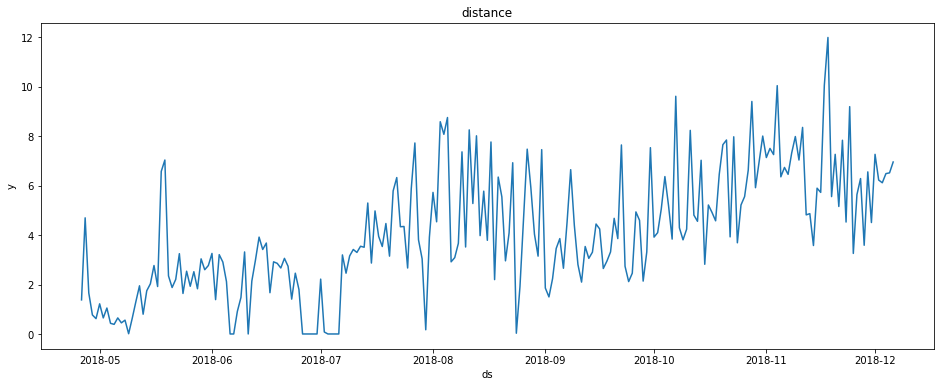

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


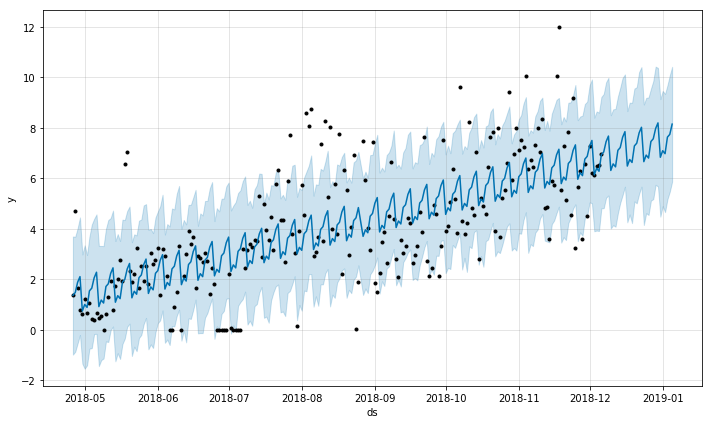

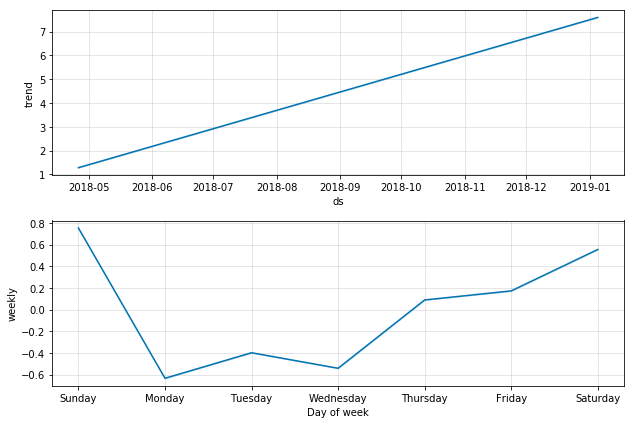

INFO:fbprophet:Making 25 forecasts with cutoffs between 2018-06-07 00:00:00 and 2018-11-22 00:00:00


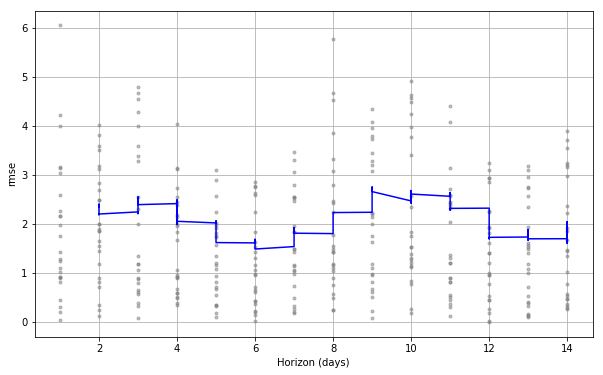

    horizon       mse      rmse       mae  mape  coverage
347 14 days  4.570973  2.137983  1.744128   inf  0.658046


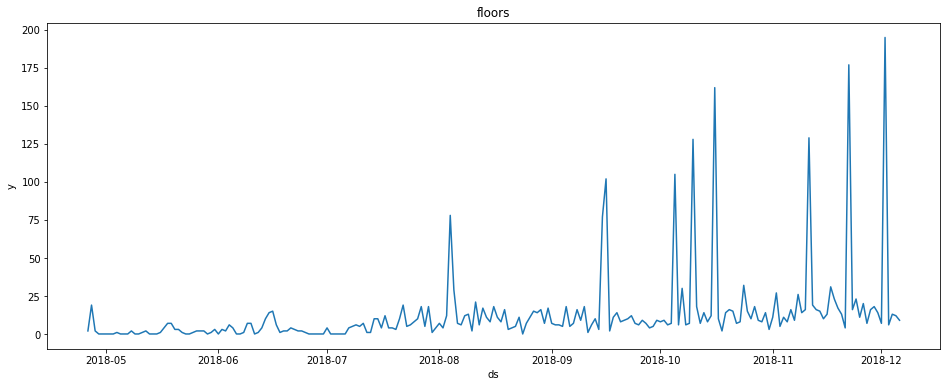

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


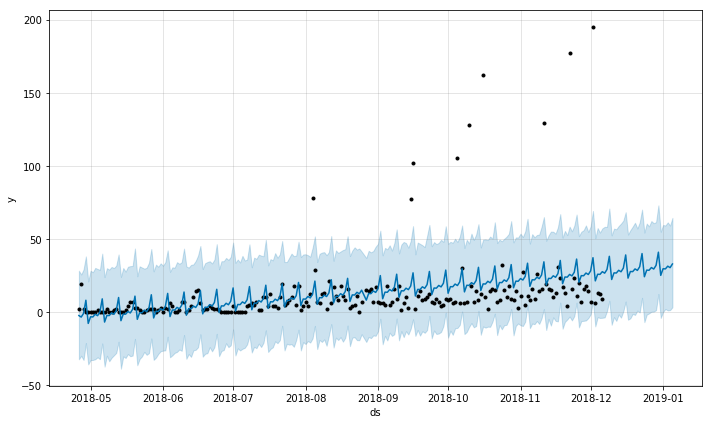

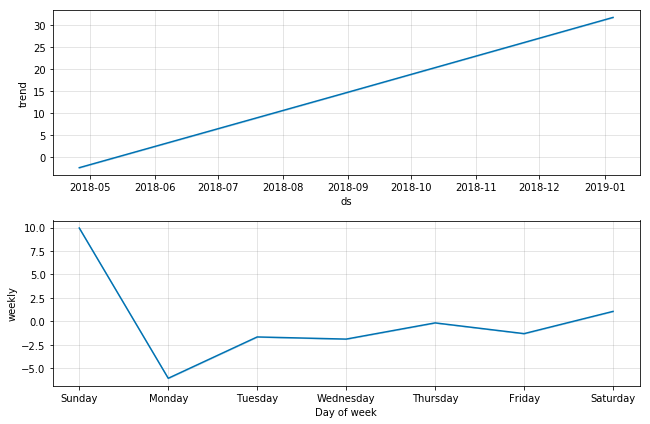

INFO:fbprophet:Making 25 forecasts with cutoffs between 2018-06-07 00:00:00 and 2018-11-22 00:00:00


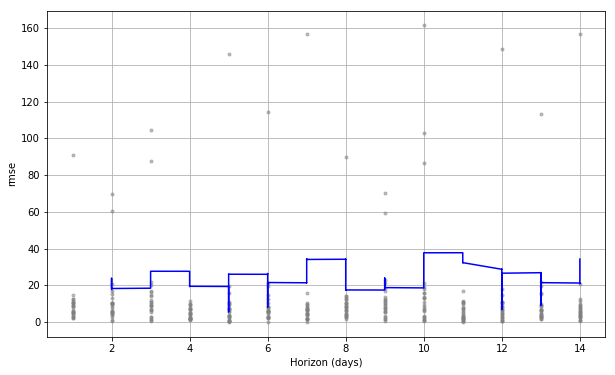

    horizon         mse       rmse        mae  mape  coverage
347 14 days  688.219661  26.233941  11.989616   inf  0.752874


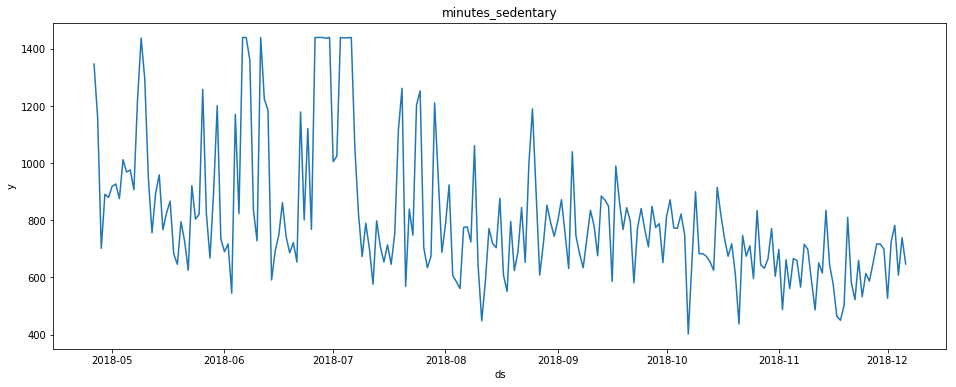

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


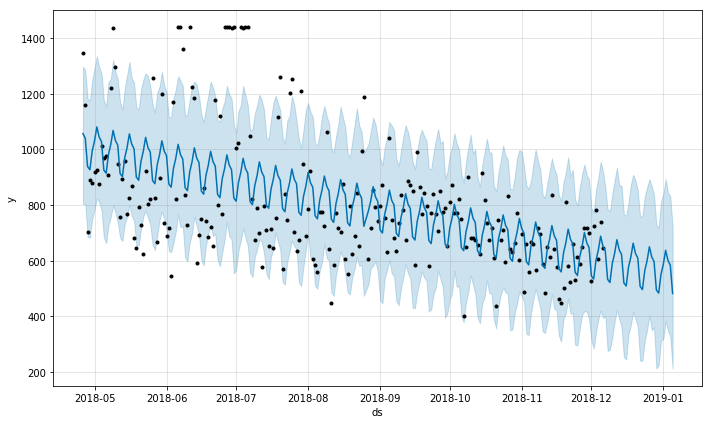

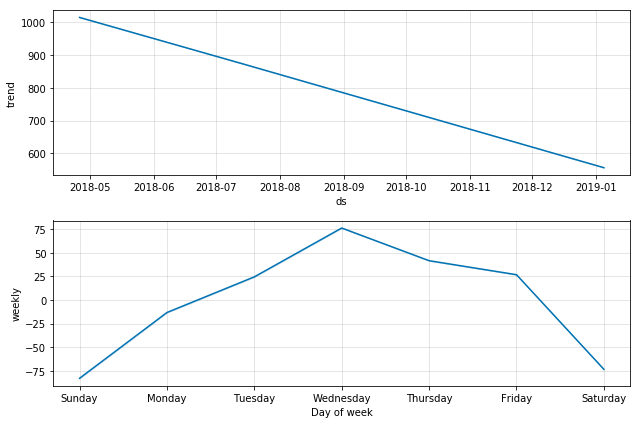

INFO:fbprophet:Making 25 forecasts with cutoffs between 2018-06-07 00:00:00 and 2018-11-22 00:00:00


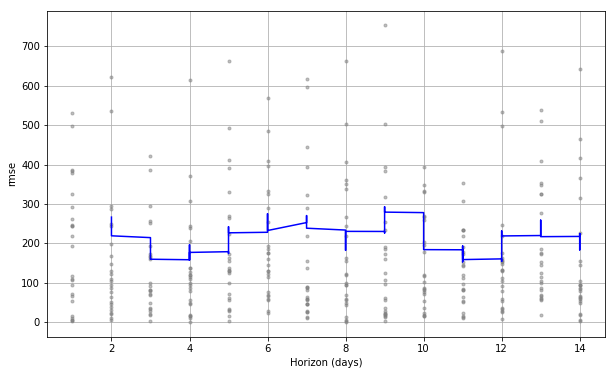

    horizon           mse        rmse         mae      mape  coverage
347 14 days  50111.881735  223.856833  164.681655  0.208835   0.83046


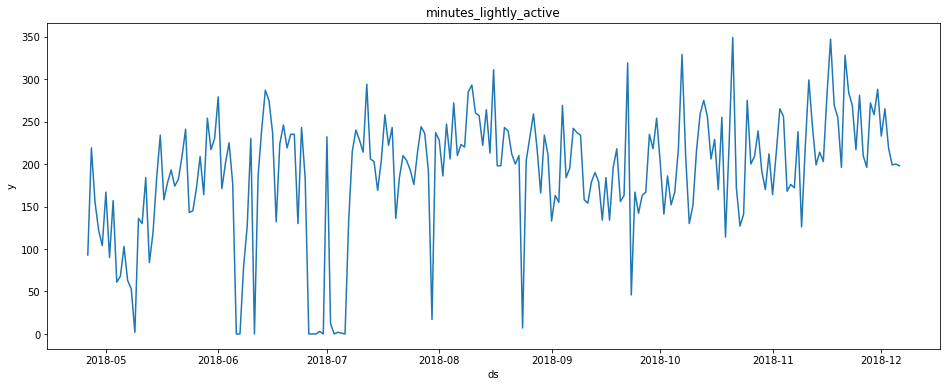

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


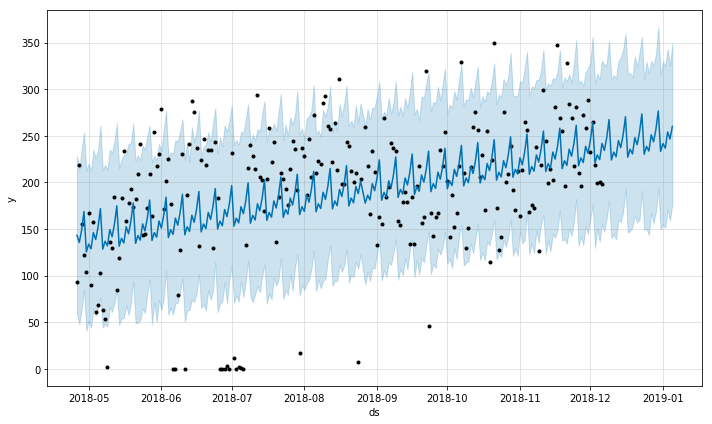

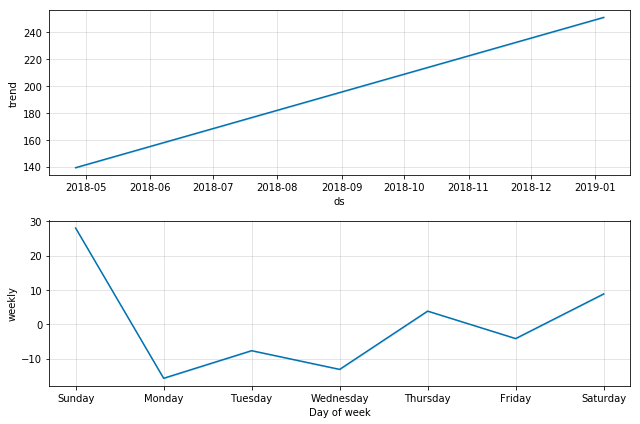

INFO:fbprophet:Making 25 forecasts with cutoffs between 2018-06-07 00:00:00 and 2018-11-22 00:00:00


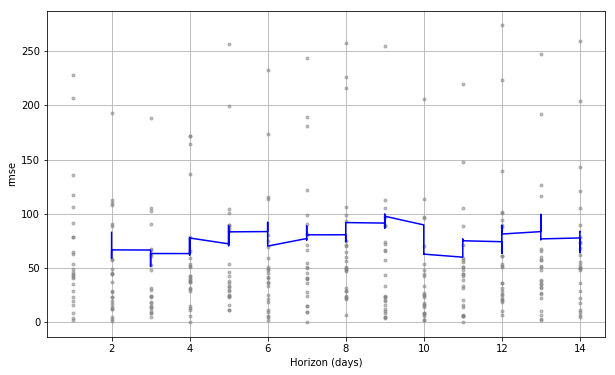

    horizon          mse       rmse        mae  mape  coverage
347 14 days  6436.725083  80.229203  58.264046   inf  0.836207


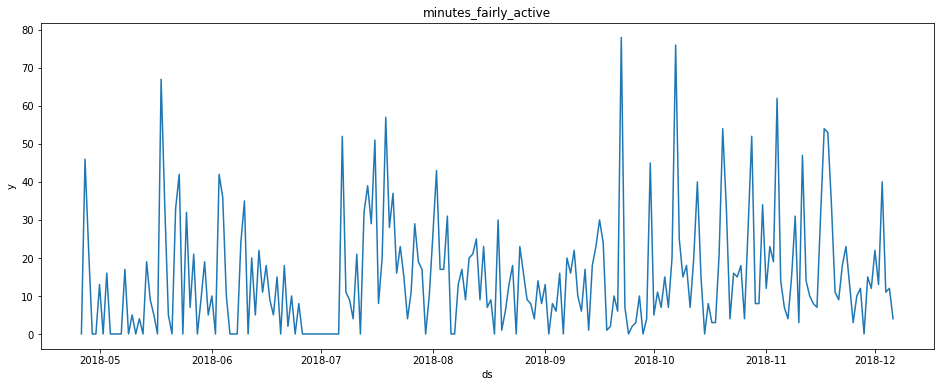

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


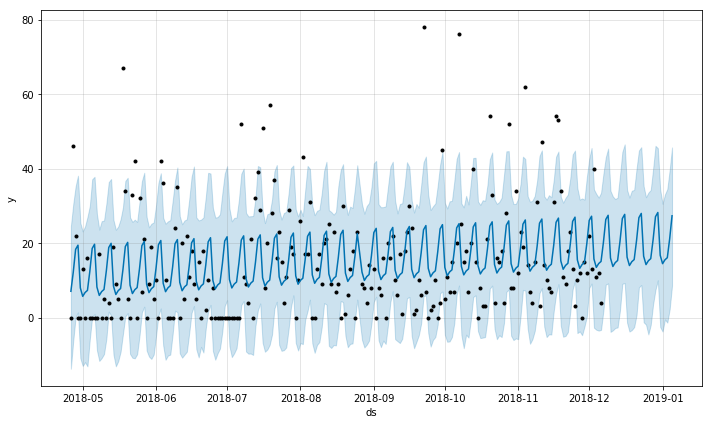

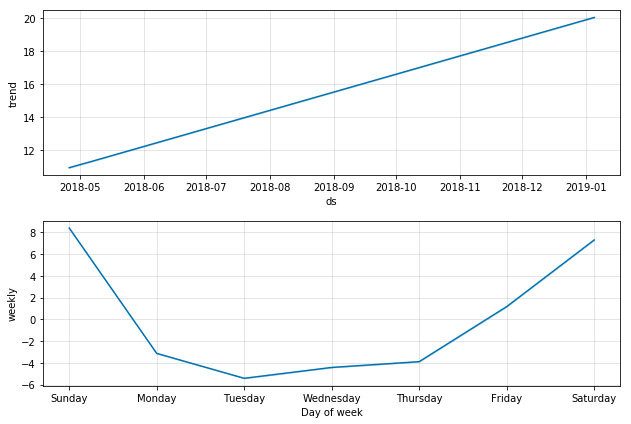

INFO:fbprophet:Making 25 forecasts with cutoffs between 2018-06-07 00:00:00 and 2018-11-22 00:00:00


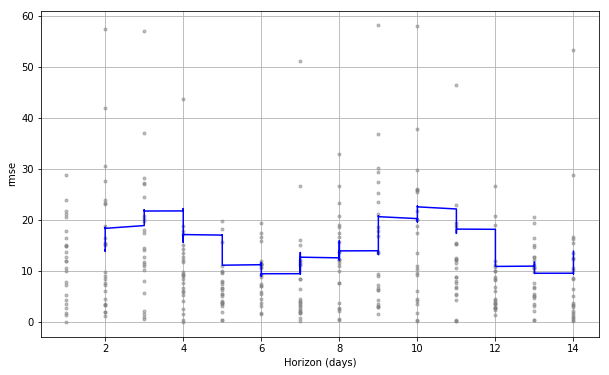

    horizon         mse       rmse        mae  mape  coverage
347 14 days  238.340243  15.438272  11.586653   inf  0.801724


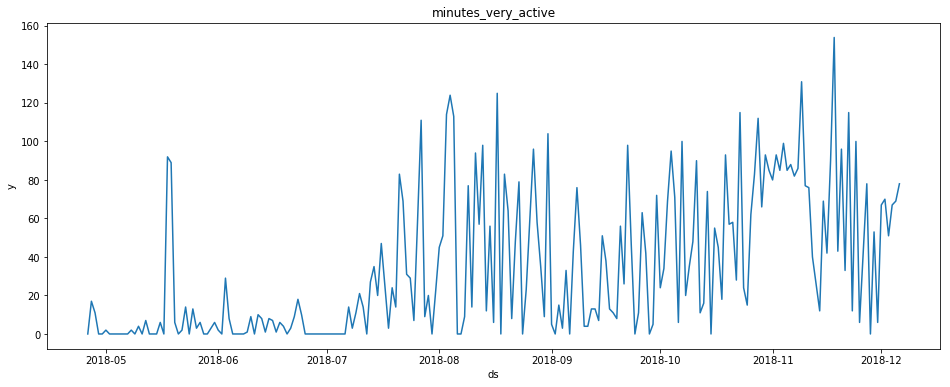

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


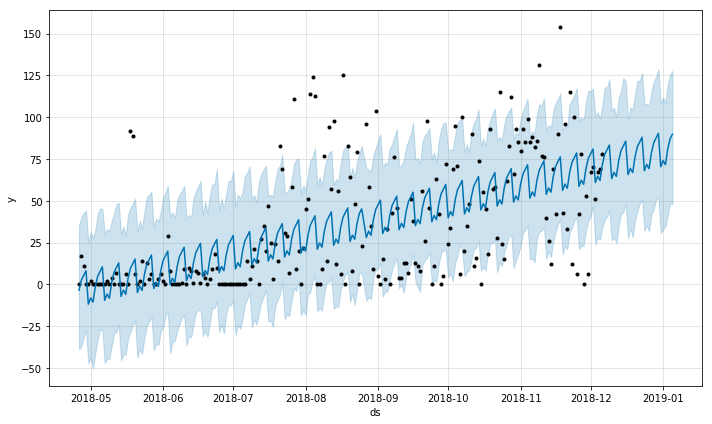

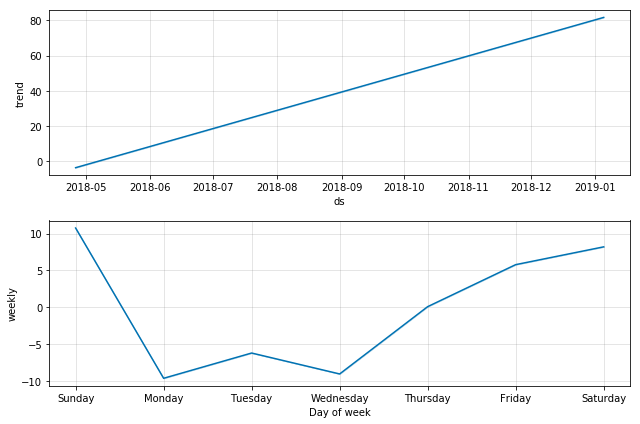

INFO:fbprophet:Making 25 forecasts with cutoffs between 2018-06-07 00:00:00 and 2018-11-22 00:00:00


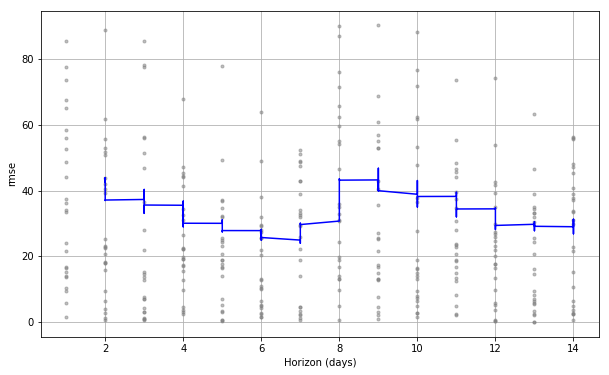

    horizon          mse       rmse        mae  mape  coverage
347 14 days  1206.686008  34.737386  27.271872   inf  0.632184


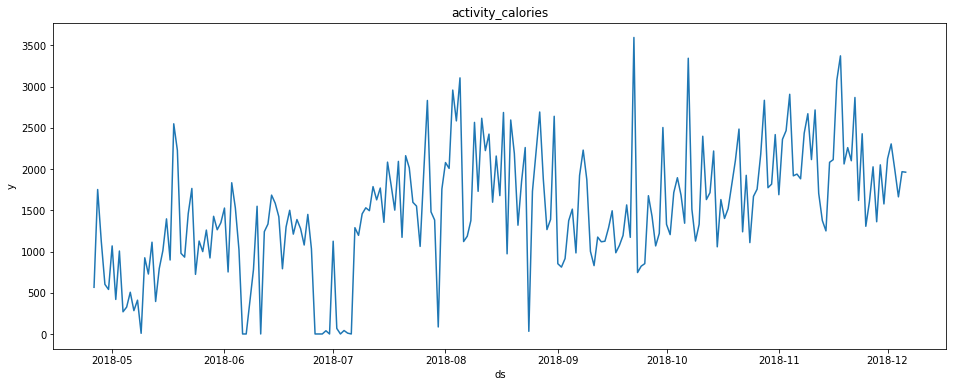

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


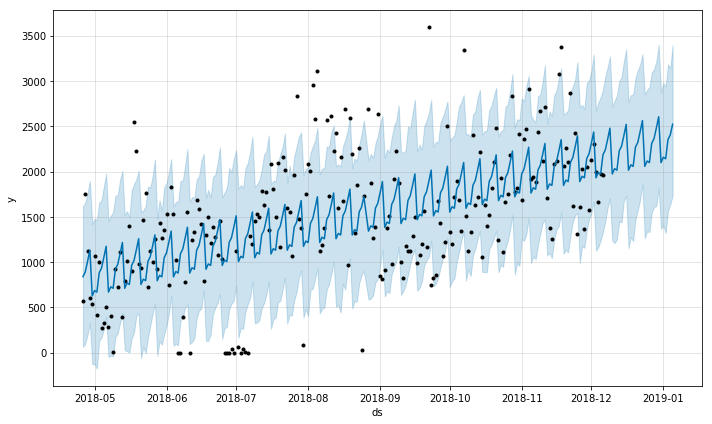

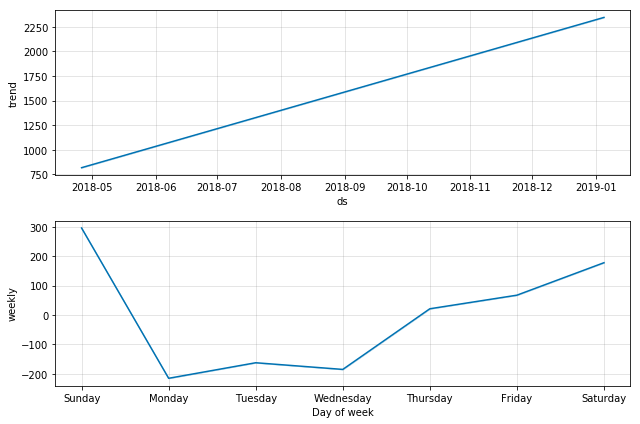

INFO:fbprophet:Making 25 forecasts with cutoffs between 2018-06-07 00:00:00 and 2018-11-22 00:00:00


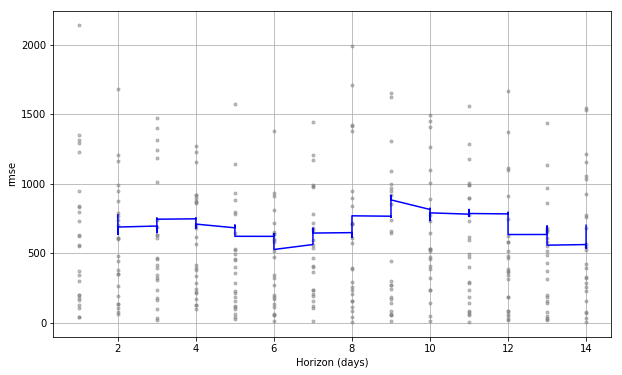

    horizon            mse        rmse         mae  mape  coverage
347 14 days  507925.011026  712.688579  565.597685   inf  0.741379


In [57]:
for col in df.columns:
    _, _, df_p = ts_prophet(df[col], 30, "14 days", weekly_seasonality=True)
    print(df_p)

### Summarize Conclusions

We chose Holt's Exponential Smoothing without any hyperparameters. It made predictions with the lowest Root Mean Squared Error, even compared to Prophet with weekly seasonality and various hyperparameter tuning. The downside to the Holt model is that is linear and either increases, decreases, or stays flat. This would be unacceptable if we were forecasting for months because the predictions would become increasingly inaccurate for this dataset. In this case, Prophet would probably be the choice.

In our opinion, the wearer of the Fitbit is an employee. We excluded a fitness equipment tester because heavy activity occurs on the weekends and it was worn on average 17 hours every day. We would expect a tester to wear the Fitbit during the week and during work hours. We excluded a drug trial participant because we would expect more rigorous logging of food. For the same reason, we excluded someone undergoing "ethical" experimentation. However, we had less confidence excluding this person because of the vague description of the experimentation.